In [1]:
import numpy as np
import pandas as pd
import os
import gc
import seaborn as sns
import matplotlib.pyplot as plt
import time
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler, LabelEncoder
from itertools import product
import lightgbm as lgb
import optuna.integration.lightgbm as lgb_optuna

In [2]:
from IPython.display import set_matplotlib_formats

## Windows의 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')

## Mac의 한글 폰트 설정
# plt.rc('font', family='AppleGothic')

plt.rc('axes', unicode_minus=False)

# 폰트가 선명하게 보이기 위해
set_matplotlib_formats('retina')

C:\Users\jjunghu\AppData\Local\Temp/ipykernel_2984/2805852763.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [3]:
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
plt.rcParams['axes.unicode_minus'] = False

In [4]:
# 데이터 불러오기
sales = pd.read_csv('./data/sales_train.csv', parse_dates=['date'])
items = pd.read_csv('./data/items.csv')
item_categories = pd.read_csv('./data/item_categories.csv')
shops = pd.read_csv('./data/shops.csv')
test = pd.read_csv('./data/test.csv')
sample_submission = pd.read_csv('./data/sample_submission.csv')

# 1. Preprocessing

## 1) shops data

- shop이 위치한 city_name 컬럼 추가

In [5]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [6]:
# shop name 확인
shops['shop_name'].value_counts()

!Якутск Орджоникидзе, 56 фран                      1
!Якутск ТЦ "Центральный" фран                      1
Москва ТЦ "Серебряный Дом"                         1
Мытищи ТРК "XL-3"                                  1
Н.Новгород ТРЦ "РИО"                               1
Н.Новгород ТРЦ "Фантастика"                        1
Новосибирск ТРЦ "Галерея Новосибирск"              1
Новосибирск ТЦ "Мега"                              1
Омск ТЦ "Мега"                                     1
РостовНаДону ТРК "Мегацентр Горизонт"              1
РостовНаДону ТРК "Мегацентр Горизонт" Островной    1
РостовНаДону ТЦ "Мега"                             1
СПб ТК "Невский Центр"                             1
СПб ТК "Сенная"                                    1
Самара ТЦ "Мелодия"                                1
Самара ТЦ "ПаркХаус"                               1
Сергиев Посад ТЦ "7Я"                              1
Сургут ТРЦ "Сити Молл"                             1
Томск ТРЦ "Изумрудный Город"                  

In [7]:
# 도시명을 공백(' ')을 기준으로 분리하기 위해 수정
shops.loc[shops.shop_name == 'Сергиев Посад', 'shop_name'] = 'СергиевПосад'
# Сергиев Посад : 세르기예프 포사트 (러시아 모스크바주에 위치한 도시)

In [8]:
shops['city_name'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops['city_name'].unique()

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

In [9]:
shops.loc[shops['city_name']=='!Якутск', 'city_name'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city_name']).astype(np.int8)
shops.head()

,shop_name,shop_id,city_name,city_code
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,29
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,29
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,1
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,2


## 3) item_categories data
- item_category_name을 라벨인코딩하여 main/sub-category 생성

In [10]:
item_categories['item_maincategory_name'] = item_categories['item_category_name'].str.split(' - ').map(lambda x: x[0])
item_categories['item_maincategory_name'].unique()

array(['PC', 'Аксессуары', 'Билеты (Цифра)', 'Доставка товара',
       'Игровые консоли', 'Игры', 'Игры Android', 'Игры MAC', 'Игры PC',
       'Карты оплаты (Кино, Музыка, Игры)', 'Карты оплаты', 'Кино',
       'Книги', 'Музыка', 'Подарки', 'Программы', 'Служебные',
       'Чистые носители (шпиль)', 'Чистые носители (штучные)',
       'Элементы питания'], dtype=object)

In [11]:
item_categories['item_subcategory_name'] = item_categories['item_category_name'].str.split('-').map(lambda x: '-'.join(x[1:]).strip() if len(x) > 1 else x[0].strip())
item_categories['item_subcategory_name'].unique()

array(['Гарнитуры/Наушники', 'PS2', 'PS3', 'PS4', 'PSP', 'PSVita',
       'XBOX 360', 'XBOX ONE', 'Билеты (Цифра)', 'Доставка товара',
       'Прочие', 'Аксессуары для игр', 'Цифра', 'Дополнительные издания',
       'Коллекционные издания', 'Стандартные издания',
       'Карты оплаты (Кино, Музыка, Игры)', 'Live!', 'Live! (Цифра)',
       'PSN', 'Windows (Цифра)', 'Blu-Ray', 'Blu-Ray 3D', 'Blu-Ray 4K',
       'DVD', 'Коллекционное', 'Артбуки, энциклопедии', 'Аудиокниги',
       'Аудиокниги (Цифра)', 'Аудиокниги 1С', 'Бизнес литература',
       'Комиксы, манга', 'Компьютерная литература',
       'Методические материалы 1С', 'Открытки',
       'Познавательная литература', 'Путеводители',
       'Художественная литература', 'CD локального производства',
       'CD фирменного производства', 'MP3', 'Винил', 'Музыкальное видео',
       'Подарочные издания', 'Атрибутика', 'Гаджеты, роботы, спорт',
       'Мягкие игрушки', 'Настольные игры',
       'Настольные игры (компактные)', 'Открытки, на

- 동일한 값들을 가진 category 컬럼들 수정 후, 라벨인코딩

In [12]:
item_categories.loc[item_categories['item_maincategory_name']=='Игры Android', 'item_maincategory_name'] = 'Игры'
item_categories.loc[item_categories['item_maincategory_name']=='Игры MAC', 'item_maincategory_name'] = 'Игры'
item_categories.loc[item_categories['item_maincategory_name']=='Игры PC', 'item_maincategory_name'] = 'Игры'
item_categories.loc[item_categories['item_maincategory_name']=='Карты оплаты (Кино, Музыка, Игры)', 'item_maincategory_name'] = 'Карты оплаты'
item_categories.loc[item_categories['item_maincategory_name']=='Чистые носители (шпиль)', 'item_maincategory_name'] = 'Чистые носители'
item_categories.loc[item_categories['item_maincategory_name']=='Чистые носители (штучные)', 'item_maincategory_name'] = 'Чистые носители'

item_categories['item_maincategory_id'] = LabelEncoder().fit_transform(item_categories['item_maincategory_name']).astype(np.int8)
item_categories['item_subcategory_id'] = LabelEncoder().fit_transform(item_categories['item_subcategory_name']).astype(np.int8)
item_categories.head()

# Игры : 게임
# Карты оплаты: 카드(플레이스테이션 게임카드 같은것)
# Чистые носители: CD

,item_category_name,item_category_id,item_maincategory_name,item_subcategory_name,item_maincategory_id,item_subcategory_id
0,PC - Гарнитуры/Наушники,0,PC,Гарнитуры/Наушники,0,31
1,Аксессуары - PS2,1,Аксессуары,PS2,1,11
2,Аксессуары - PS3,2,Аксессуары,PS3,1,12
3,Аксессуары - PS4,3,Аксессуары,PS4,1,13
4,Аксессуары - PSP,4,Аксессуары,PSP,1,15


- sales 데이터의 item_price, item_cnt_day 음수값 처리

In [13]:
sales = sales[sales.item_price > 0] # 음수 값 처리

In [14]:
# item_cnt_day 음수값은 환불된 것으로 추정 -> 환불모듈 적용

k = sales[sales.item_cnt_day < 0]
timefunc = time.time()
for i in range(len(k)):
    try:
        a = (sales[(sales.item_id == k.iloc[i,3]) & (sales.shop_id == k.iloc[i,2])])
        if a.date.min() < k.iloc[i,0]:
            h = a[(a.date==a.date[a.date < k.iloc[i,0]].max())].index[0]
            if sales.loc[h,'item_cnt_day'] > abs(k.iloc[i,5]):
                sales.loc[h,'item_cnt_day'] += k.iloc[i,5]
        else:
            pass
    except:
        pass
sales.drop(sales[sales.item_cnt_day < 0].index, axis = 0,inplace = True)
print(time.time() - timefunc)
sales.head(), sales.shape

143.94032526016235


(        date  date_block_num  shop_id  item_id  item_price  item_cnt_day
 0 2013-02-01               0       59    22154      999.00           1.0
 1 2013-03-01               0       25     2552      899.00           1.0
 3 2013-06-01               0       25     2554     1709.05           1.0
 4 2013-01-15               0       25     2555     1099.00           1.0
 5 2013-10-01               0       25     2564      349.00           1.0,
 (2928492, 6))

- sales, items, item_categories 데이터프레임 merge
- test, shops 데이터프레임 merge

In [15]:
item_info = pd.merge(items, item_categories, on='item_category_id', how='inner')
train_tmp = pd.merge(sales,item_info, on='item_id', how='inner')
train = pd.merge(train_tmp, shops, on='shop_id', how='inner')
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,item_maincategory_name,item_subcategory_name,item_maincategory_id,item_subcategory_id,shop_name,city_name,city_code
0,2013-02-01,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,Кино,Blu-Ray,7,1,"Ярославль ТЦ ""Альтаир""",Ярославль,30
1,2013-05-16,4,59,2573,249.0,1.0,DEL REY LANA Born To Die,55,Музыка - CD локального производства,Музыка,CD локального производства,9,4,"Ярославль ТЦ ""Альтаир""",Ярославль,30
2,2013-01-26,0,59,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,Музыка,CD локального производства,9,4,"Ярославль ТЦ ""Альтаир""",Ярославль,30
3,2013-09-01,0,59,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,Музыка,CD локального производства,9,4,"Ярославль ТЦ ""Альтаир""",Ярославль,30
4,2013-02-24,1,59,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,Музыка,CD локального производства,9,4,"Ярославль ТЦ ""Альтаир""",Ярославль,30


In [16]:
test_tmp = pd.merge(test,item_info, on='item_id', how='inner')
test = pd.merge(test_tmp, shops, on='shop_id', how='inner')
test.head()

,ID,shop_id,item_id,item_name,item_category_id,item_category_name,item_maincategory_name,item_subcategory_name,item_maincategory_id,item_subcategory_id,shop_name,city_name,city_code
0,0,5,5037,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,Игры,PS3,5,12,"Вологда ТРЦ ""Мармелад""",Вологда,3
1,1,5,5320,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,Музыка,CD локального производства,9,4,"Вологда ТРЦ ""Мармелад""",Вологда,3
2,2,5,5233,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,Игры,PS3,5,12,"Вологда ТРЦ ""Мармелад""",Вологда,3
3,3,5,5232,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360,Игры,XBOX 360,5,18,"Вологда ТРЦ ""Мармелад""",Вологда,3
4,4,5,5268,"Need for Speed [PS4, русская версия]",20,Игры - PS4,Игры,PS4,5,13,"Вологда ТРЦ ""Мармелад""",Вологда,3


- 중복값 제거

In [17]:
sales.duplicated().sum()

6

In [18]:
sales = sales.drop_duplicates()
sales.shape

(2928486, 6)

- revenue(하루 판매 매출액) 컬럼 생성

In [19]:
train['revenue'] = train['item_price'] * train['item_cnt_day']
train.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,item_maincategory_name,item_subcategory_name,item_maincategory_id,item_subcategory_id,shop_name,city_name,city_code,revenue
0,2013-02-01,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,Кино,Blu-Ray,7,1,"Ярославль ТЦ ""Альтаир""",Ярославль,30,999.0
1,2013-05-16,4,59,2573,249.0,1.0,DEL REY LANA Born To Die,55,Музыка - CD локального производства,Музыка,CD локального производства,9,4,"Ярославль ТЦ ""Альтаир""",Ярославль,30,249.0
2,2013-01-26,0,59,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,Музыка,CD локального производства,9,4,"Ярославль ТЦ ""Альтаир""",Ярославль,30,399.0


In [20]:
train['date_block_num'] =train['date_block_num'].astype(np.int8)
train['shop_id'] = train['shop_id'].astype(np.int8)
train['item_id'] = train['item_id'].astype(np.int16)
train['item_category_id'] = train['item_category_id'].astype(np.int16)

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928492 entries, 0 to 2928491
Data columns (total 17 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date                    datetime64[ns]
 1   date_block_num          int8          
 2   shop_id                 int8          
 3   item_id                 int16         
 4   item_price              float64       
 5   item_cnt_day            float64       
 6   item_name               object        
 7   item_category_id        int16         
 8   item_category_name      object        
 9   item_maincategory_name  object        
 10  item_subcategory_name   object        
 11  item_maincategory_id    int8          
 12  item_subcategory_id     int8          
 13  shop_name               object        
 14  city_name               object        
 15  city_code               int8          
 16  revenue                 float64       
dtypes: datetime64[ns](1), float64(3), int16(2), in

In [22]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
test['item_category_id'] = test['item_category_id'].astype(np.int16)

# 2. EDA

- categories 와 shops에서 '가장 인기있는 items'
- 매일의 item price와 item sales 분포
- 연 판매량을 보면서 추세 파악하기
- 이상치와 결측값 확인하기

## 1) Shops Analysis

In [23]:
shop_rank = pd.DataFrame(train.shop_name.value_counts())
shop_rank.reset_index(inplace=True)
shop_rank.columns = ['shop_name', 'counts']
shop_rank.head()

,shop_name,counts
0,"Москва ТЦ ""Семеновский""",235185
1,"Москва ТРК ""Атриум""",185788
2,"Химки ТЦ ""Мега""",143124
3,"Москва ТЦ ""МЕГА Теплый Стан"" II",142018
4,"Якутск Орджоникидзе, 56",117114


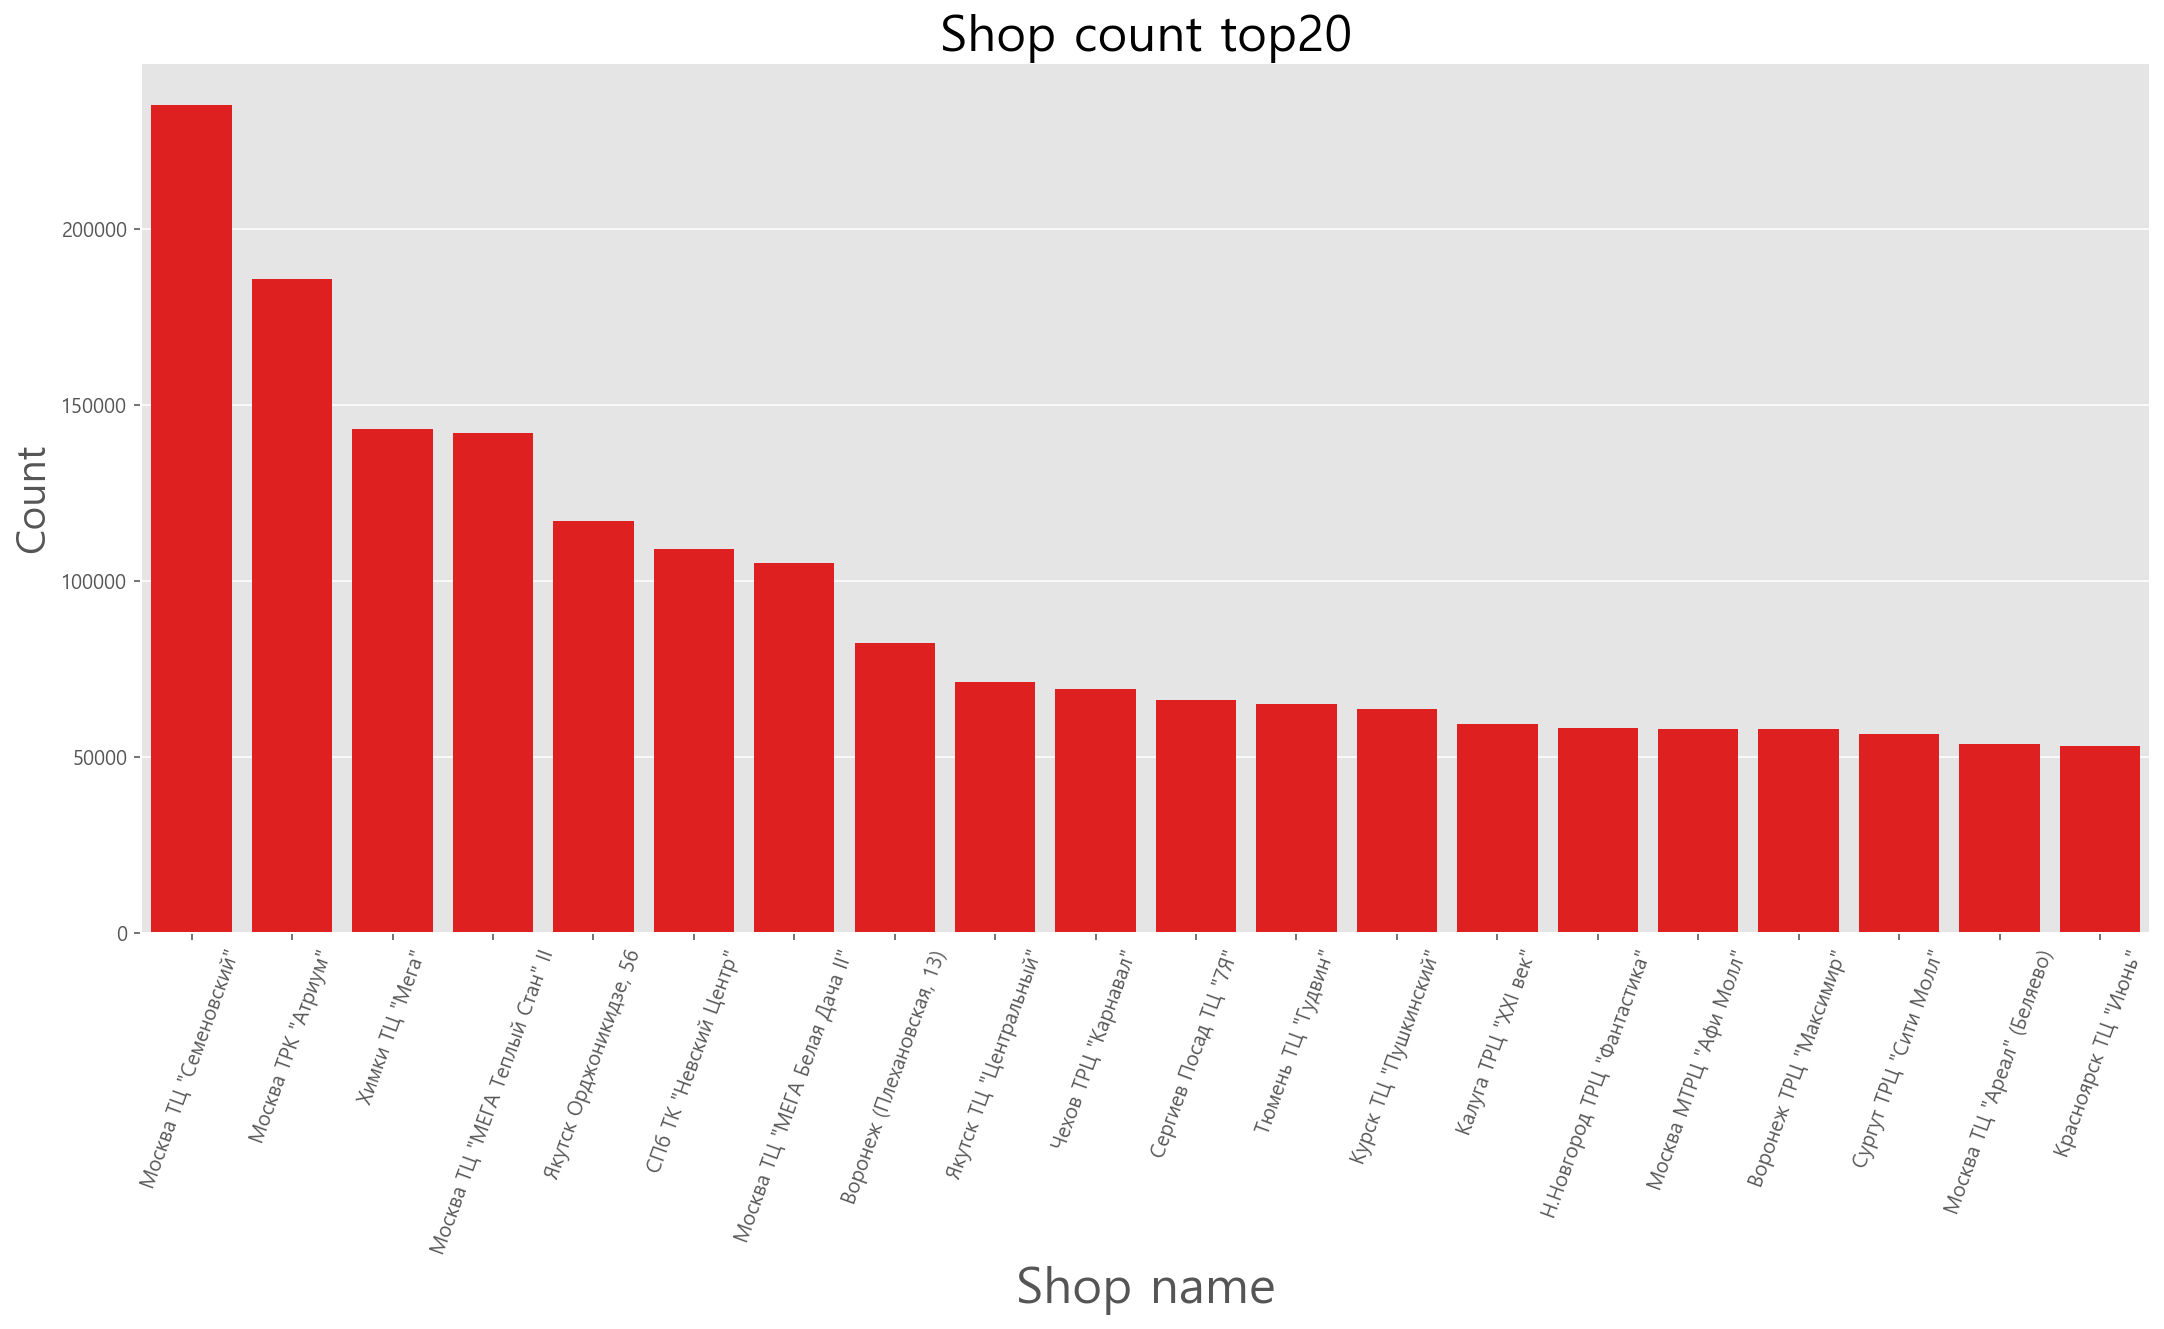

In [24]:
fig, axes = plt.subplots(1,1,figsize = (18,8))
plt.style.use('ggplot')

plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

ax=sns.barplot(x='shop_name',y='counts', data=shop_rank[0:20], color='r')
ax.set_title('Shop count top20', fontsize=25)
ax.set_xlabel('Shop name', fontsize=25)
ax.set_ylabel('Count', fontsize=20)
plt.xticks(rotation=70)
plt.show()

Top5 shops
1. Moscow Shopping Center "Semenovsky"
2. Moscow TRC "Atrium"
3. Khimki Shopping Center "Mega"
4. Moscow TC "MEGA Teply Stan" II
5. Yakutsk Ordzhonikidze, 56 

In [25]:
shop_rank[0:5]

,shop_name,counts
0,"Москва ТЦ ""Семеновский""",235185
1,"Москва ТРК ""Атриум""",185788
2,"Химки ТЦ ""Мега""",143124
3,"Москва ТЦ ""МЕГА Теплый Стан"" II",142018
4,"Якутск Орджоникидзе, 56",117114


- shops 의 수가 많은 도시들을 살펴보기

In [26]:
city_count = pd.DataFrame(train['city_name'].value_counts())
city_count.reset_index(inplace=True)
city_count.columns = ['city_name', 'counts']
city_count.head()

,city_name,counts
0,Москва,994698
1,Якутск,203917
2,СПб,148073
3,Воронеж,143785
4,Химки,143124


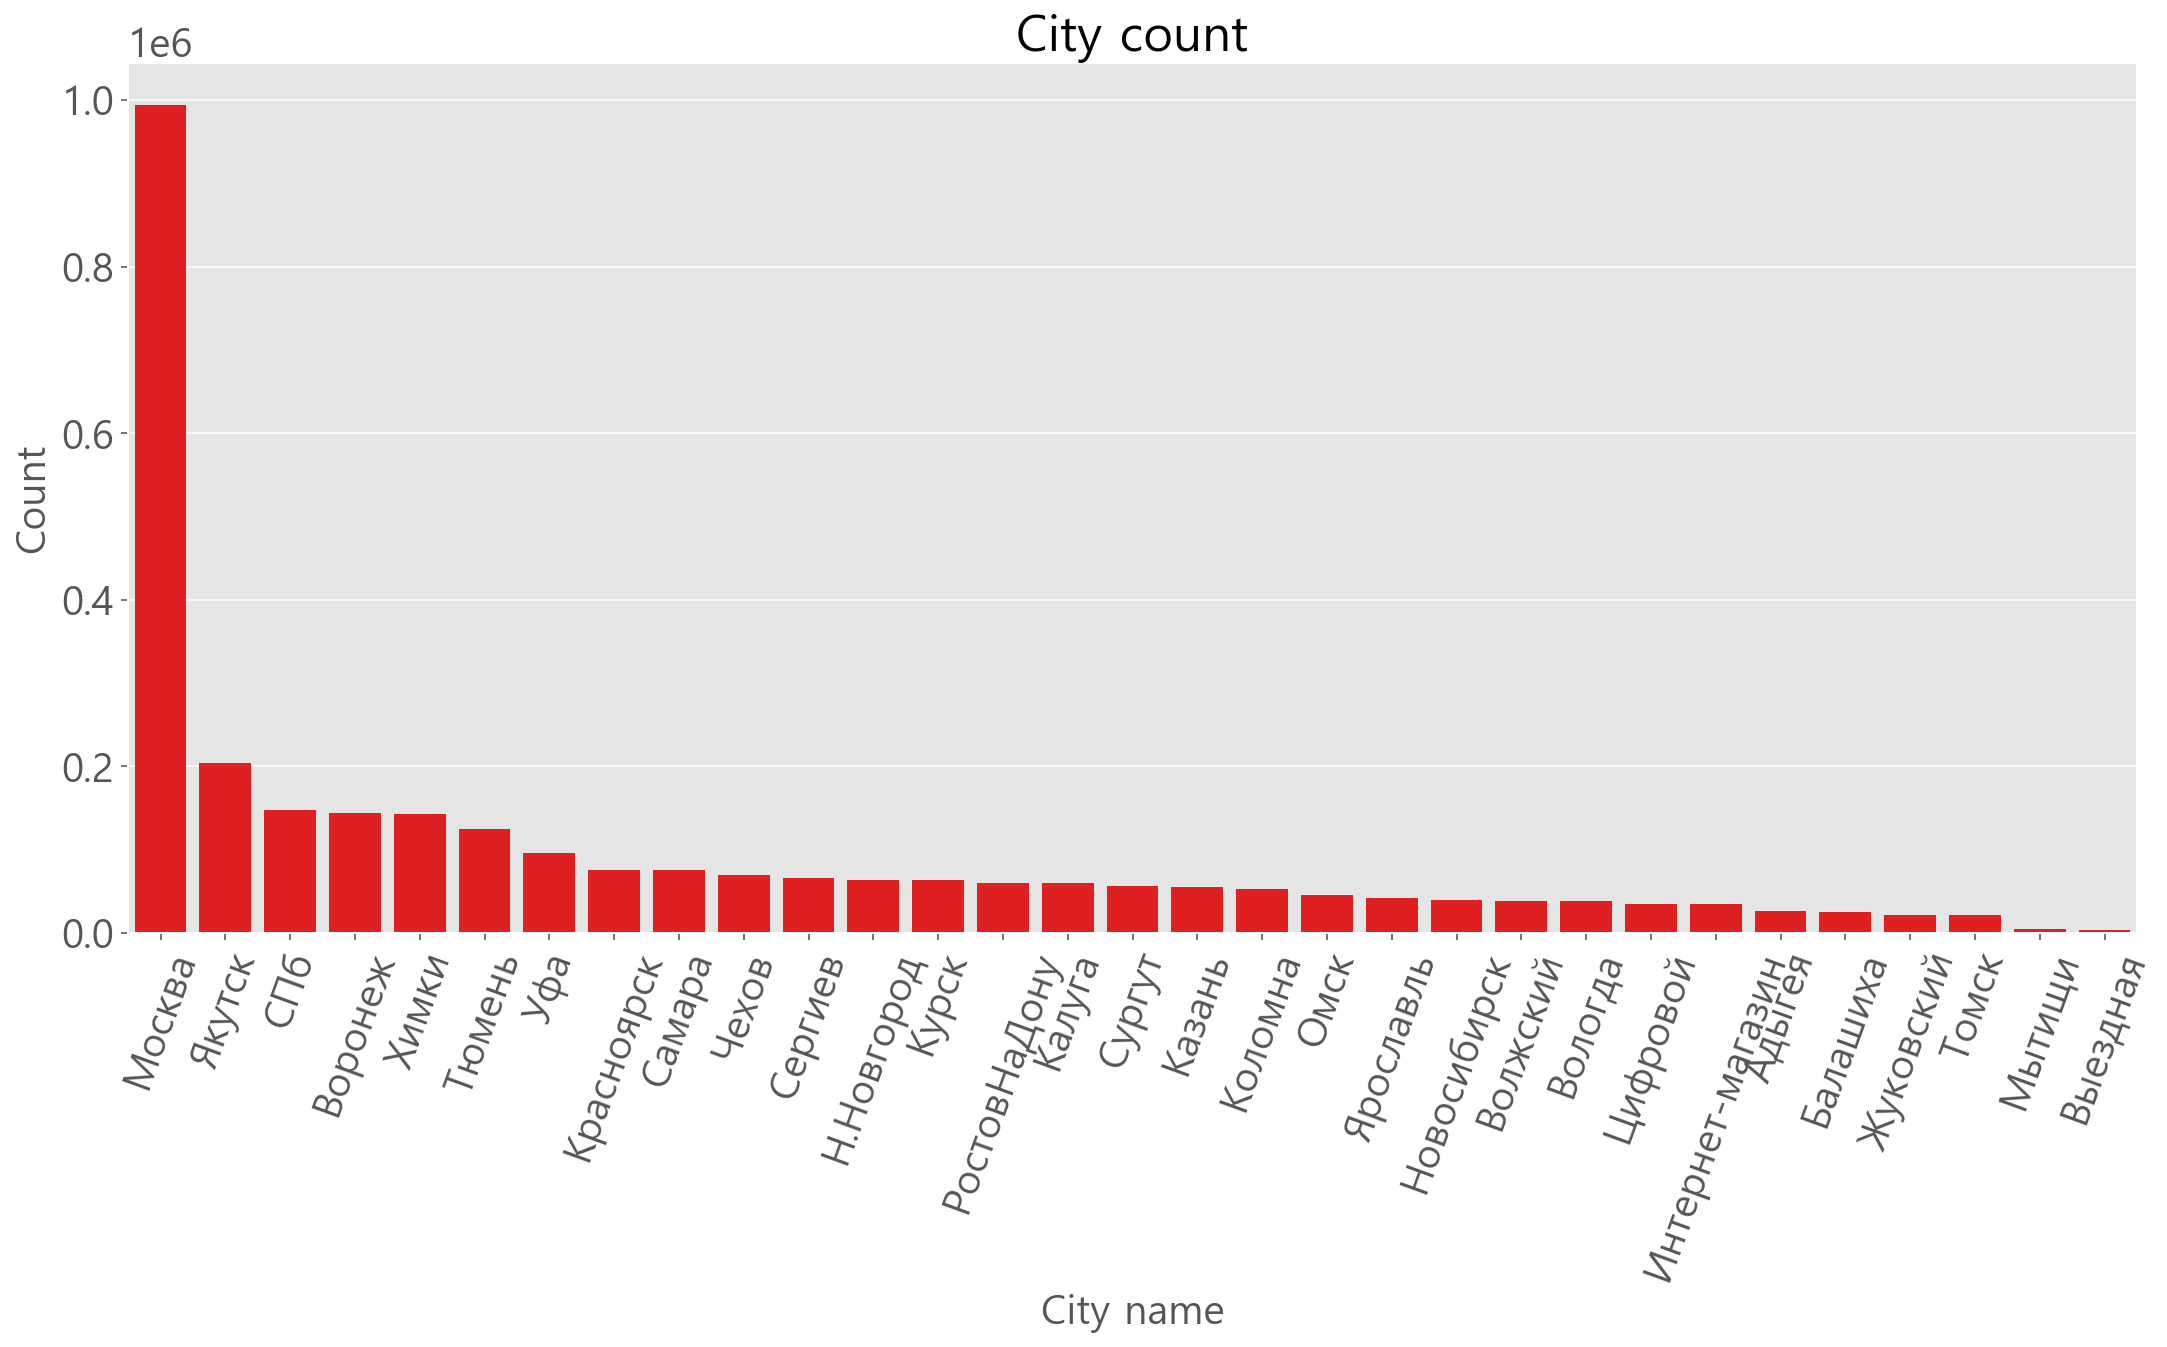

In [27]:
fig, axes = plt.subplots(1,1,figsize = (18,8))
plt.style.use('ggplot')

plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

ax=sns.barplot(x='city_name',y='counts', data=city_count, color='r')
ax.set_title('City count', fontsize=25)
ax.set_xlabel('City name', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
plt.xticks(rotation=70)
plt.show()

## 2) Item Analysis

In [28]:
item_rank=pd.DataFrame(train['item_name'].value_counts().sort_values(ascending=False))
item_rank.reset_index(inplace=True)
item_rank.columns = ['item_name', 'counts']
item_rank.head()

,item_name,counts
0,Фирменный пакет майка 1С Интерес белый (34*42)...,31337
1,Playstation Store пополнение бумажника: Карта ...,9404
2,Прием денежных средств для 1С-Онлайн,9067
3,"Diablo III [PC, Jewel, русская версия]",7470
4,Kaspersky Internet Security Multi-Device Russi...,6850


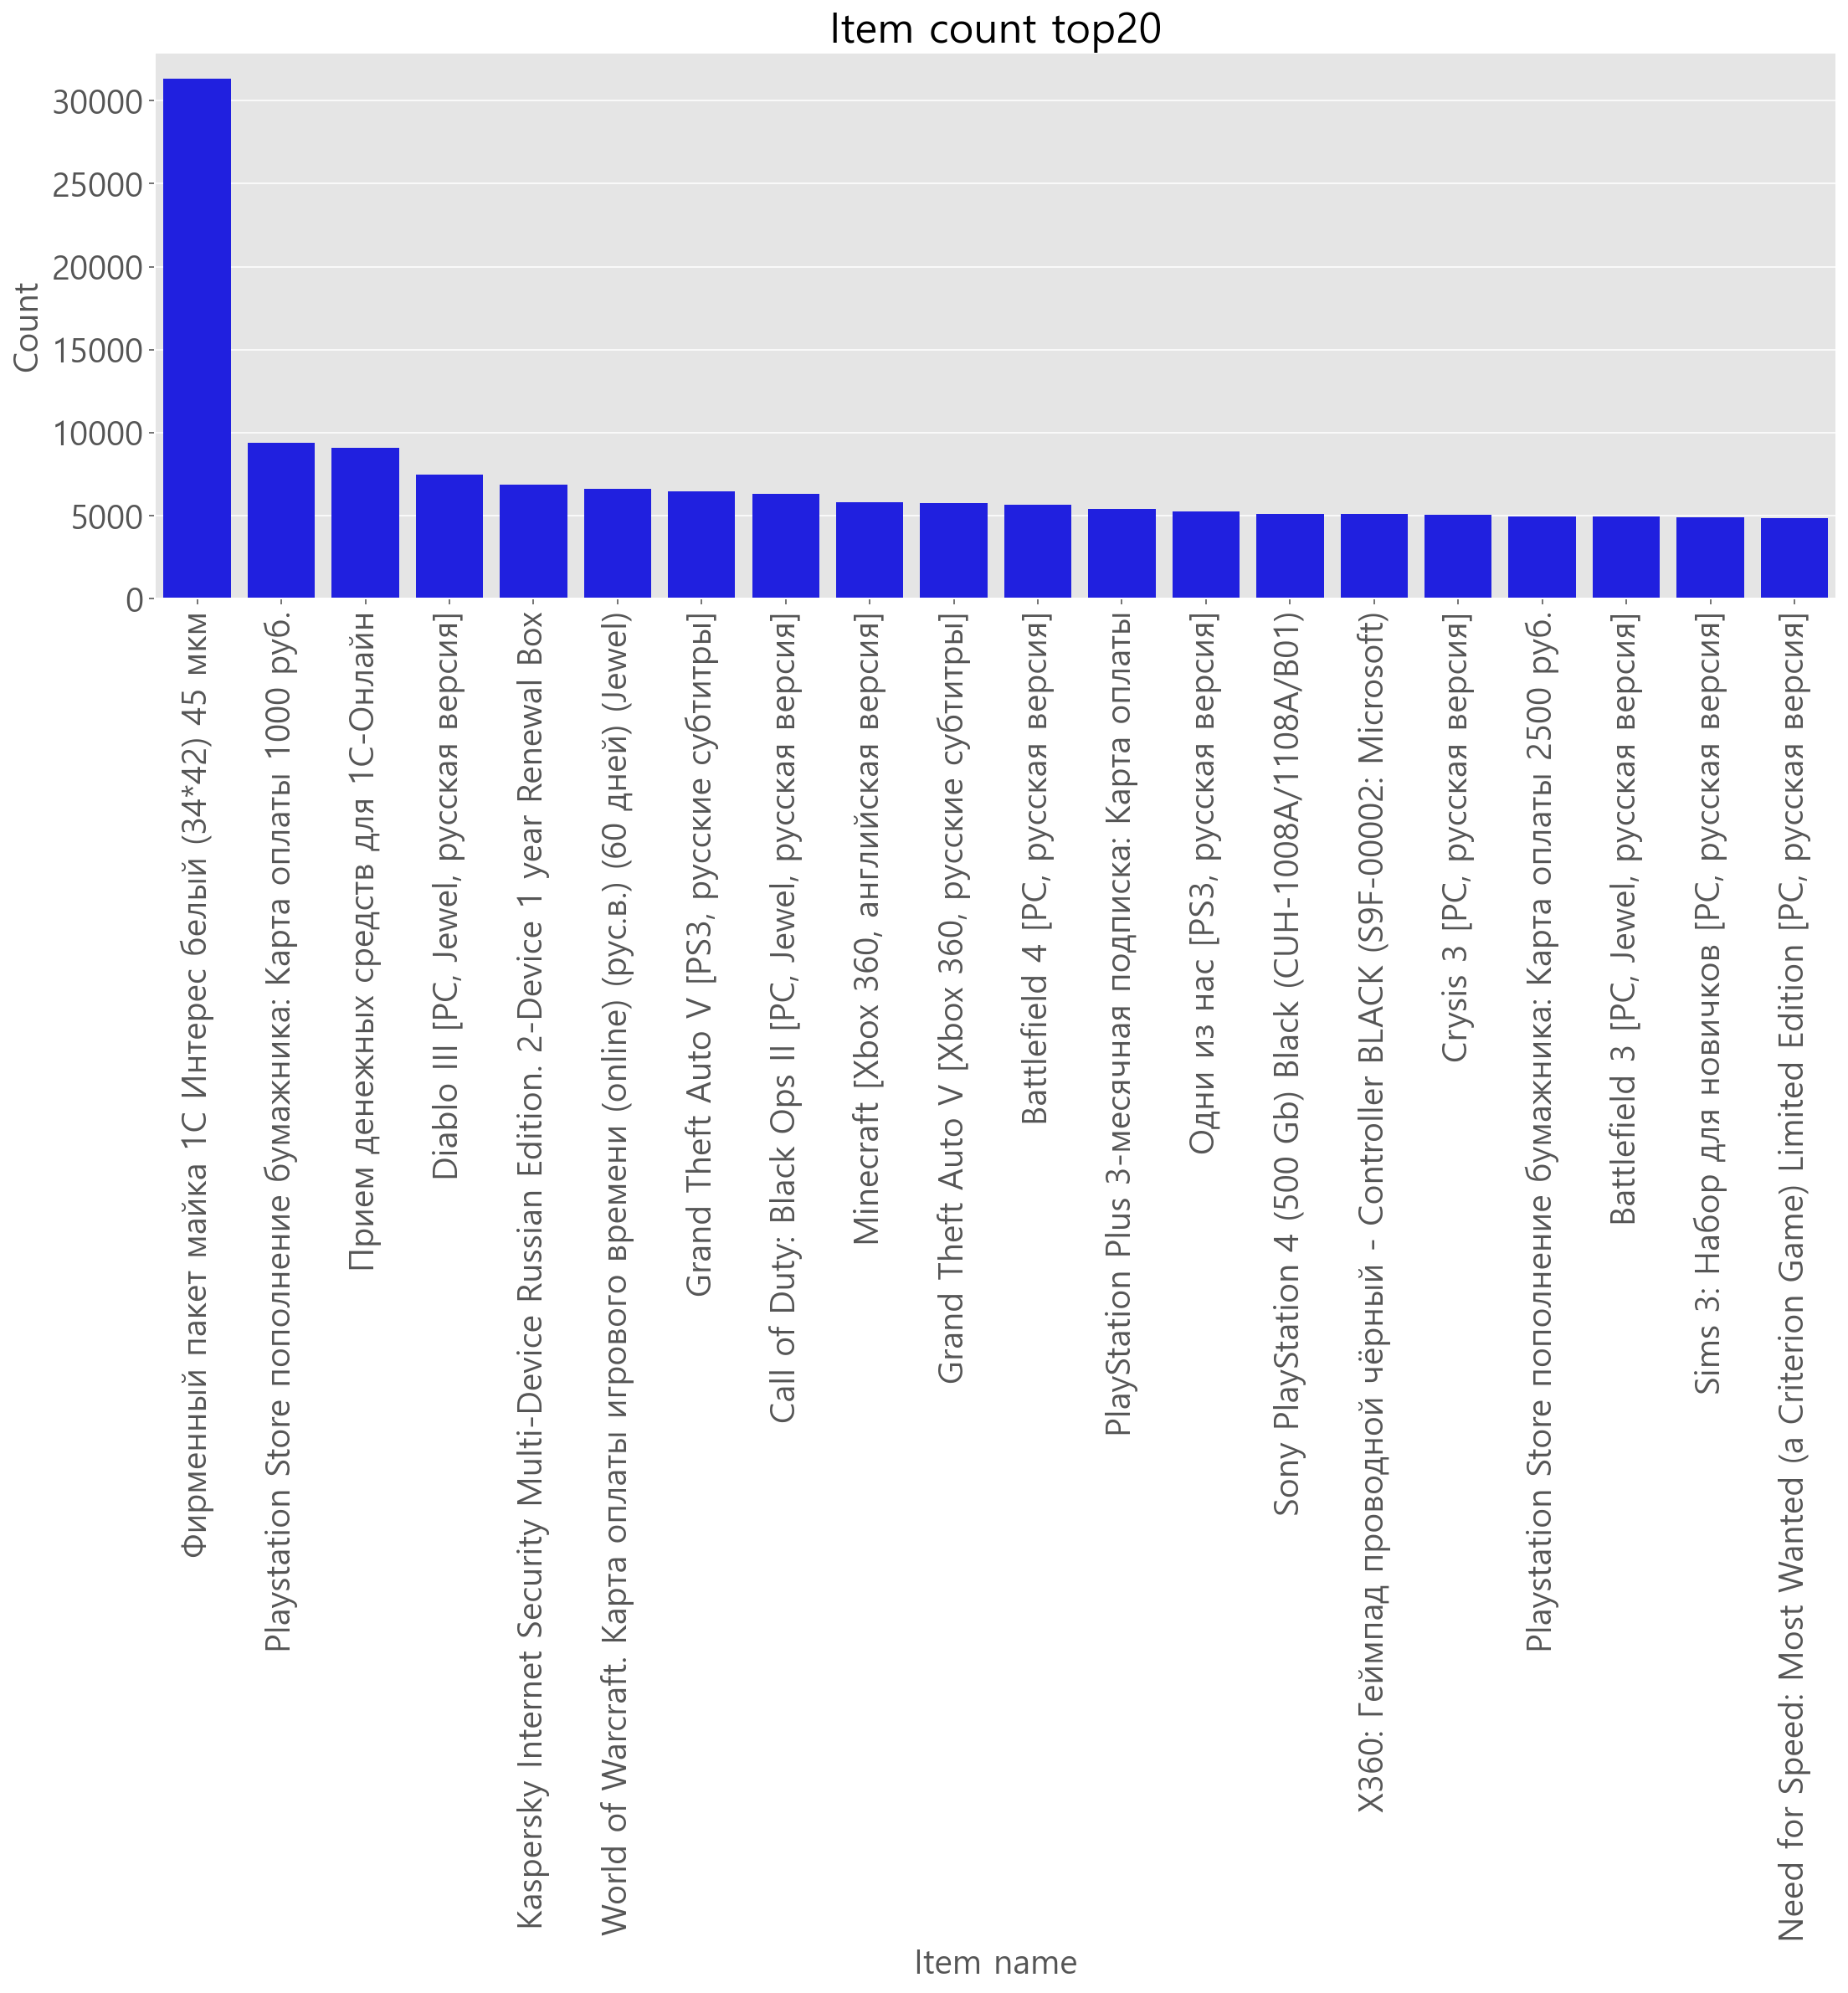

In [29]:
fig, axes = plt.subplots(1,1,figsize = (18,6))
plt.style.use('ggplot')

plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

ax=sns.barplot(x='item_name',y='counts', data=item_rank[0:20], color='b')
ax.set_title('Item count top20', fontsize=25)
ax.set_xlabel('Item name', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
plt.xticks(rotation=90)
plt.show()

Top5 item names
1. Corporate package shirt 1C Interest white (34 * 42) 45 microns
2. Playstation Store wallet replenishment: Payment card 1000 rub.
3. Acceptance of funds for 1C-Online
4. Diablo III [PC, Jewel, Russian version]
5. Kaspersky Internet Security Multi-Device Russian Edition. 2-Device 1 year Renewal Box

In [30]:
item_rank[0:5]

,item_name,counts
0,Фирменный пакет майка 1С Интерес белый (34*42)...,31337
1,Playstation Store пополнение бумажника: Карта ...,9404
2,Прием денежных средств для 1С-Онлайн,9067
3,"Diablo III [PC, Jewel, русская версия]",7470
4,Kaspersky Internet Security Multi-Device Russi...,6850


In [31]:
price_rank = train[['item_name','item_category_name','item_price']].groupby(['item_name','item_category_name']).max()
price_rank.sort_values('item_price',ascending=False).head()

,,item_price
item_name,item_category_name,
Radmin 3 - 522 лиц.,Программы - Для дома и офиса,307980.0
Доставка (EMS),Доставка товара,59200.0
Коллекционные шахматы (Властелин Колец),Подарки - Сувениры,50999.0
UserGate Proxy & Firewall 6.X с модулем фильтрации сайтов Entensys URL Filtering до 200 сессий (Academic/Social),Программы - Для дома и офиса,49782.0
"Комплект ""Microsoft Xbox One 1TB Limited Edition Halo 5 + ""Halo 5. Limited Edition"" [KF6-00012]",Игровые консоли - XBOX ONE,42990.0


Most expensive items:
1. Remote Control Software
2. Shipping cost
3. Lord of the Ring(DVD)

In [32]:
price_rank.sort_values('item_price',ascending=True).head()

,,item_price
item_name,item_category_name,
Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм,"Подарки - Сумки, Альбомы, Коврики д/мыши",5.0
Элемент питания КОСМОС LR03 2*BL,Элементы питания,7.0
"Monday Night Combat [PC, Цифровая версия]",Игры PC - Цифра,10.0
Карта города Жуковский,Подарки - Сувениры,11.0
"Щелкунчик и Крысиный король [PC, Jewel]",Игры PC - Стандартные издания,14.0


Cheapest items:
1. Corporate package
2. Battery
3. Monday Night Combat(PC Game)

## 3) Item Category Analysis

In [33]:
item_cat_rank=pd.DataFrame(train['item_category_name'].value_counts().sort_values(ascending=False))
item_cat_rank.reset_index(inplace=True)
item_cat_rank.columns = ['item_categories', 'counts']
item_cat_rank.head()

,item_categories,counts
0,Кино - DVD,563938
1,Игры PC - Стандартные издания,350787
2,Музыка - CD локального производства,339127
3,Игры - PS3,207371
4,Кино - Blu-Ray,191932


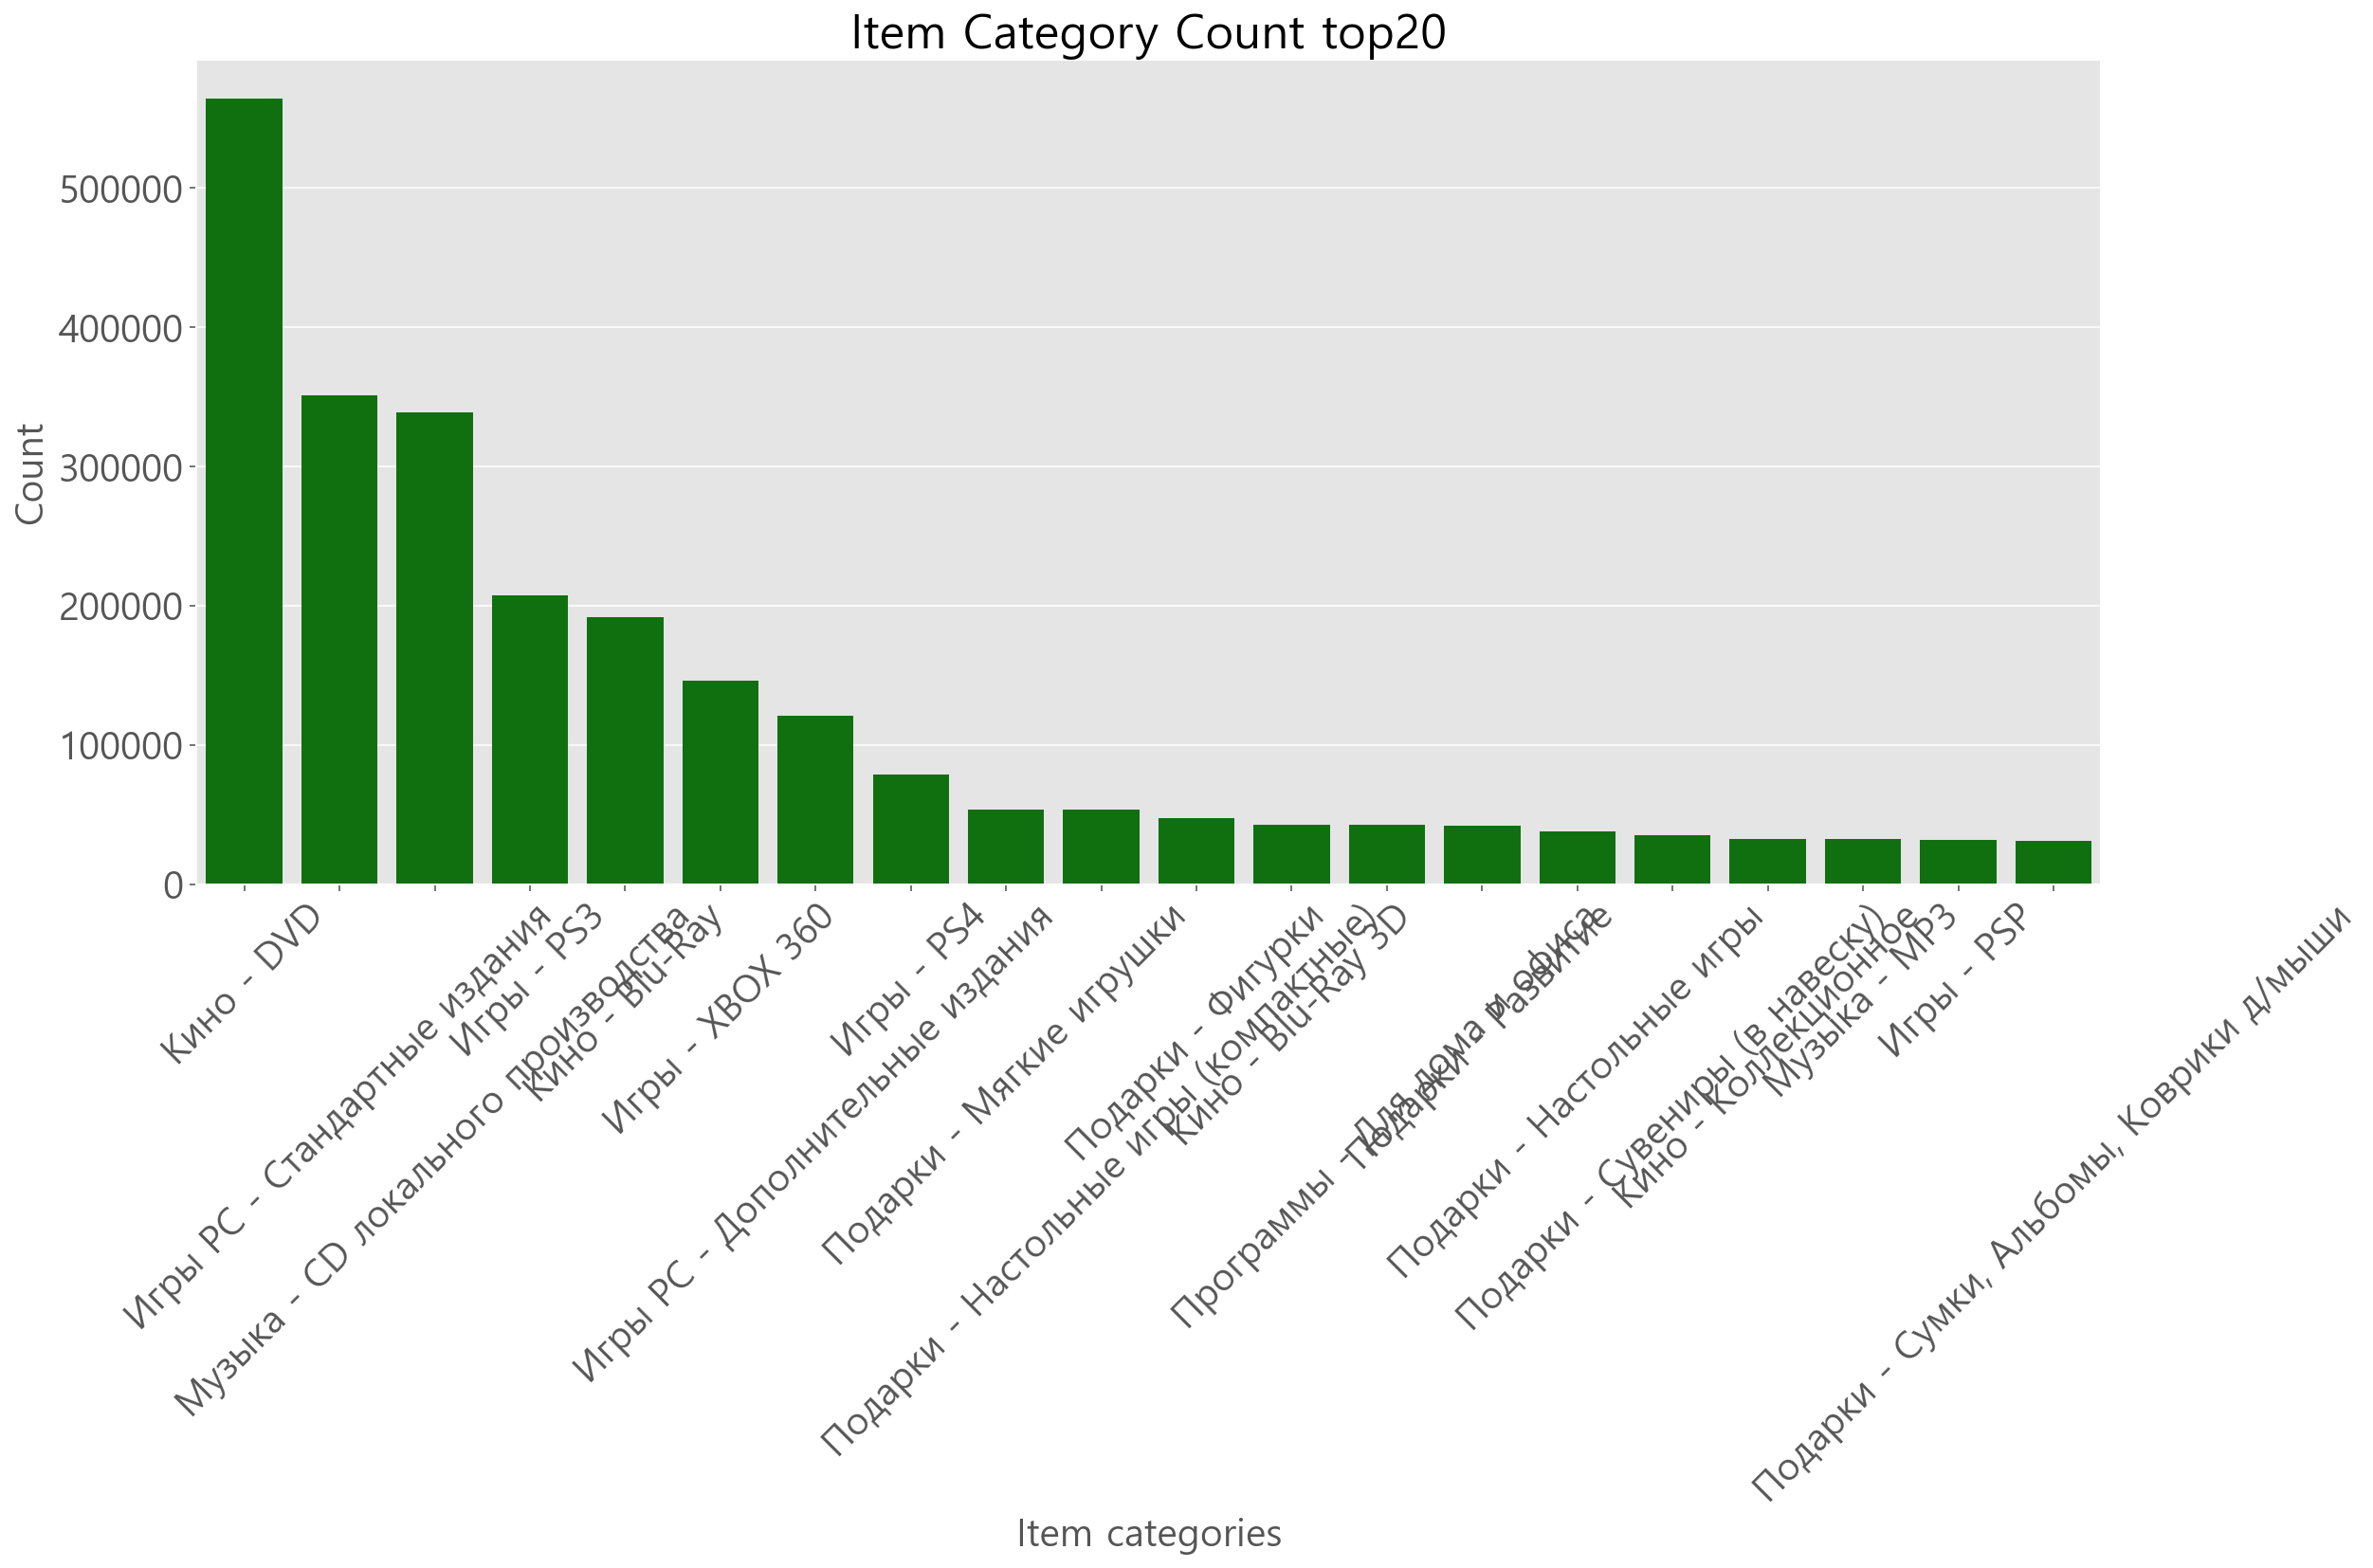

In [34]:
fig, axes = plt.subplots(1,1,figsize = (18,8))
plt.style.use('ggplot')

plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

ax=sns.barplot(x='item_categories',y='counts', data=item_cat_rank[0:20], color='g')
ax.set_title('Item Category Count top20', fontsize=25)
ax.set_xlabel('Item categories', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
plt.xticks(rotation=45)
plt.show()

- TV-game 관련 소프트웨어와 영화DVD가 잘 팔리는 것을 확인

Top5 item categories:
1. Cinema - DVD
2. PC Games - Standard Editions
3. Music - Local Production CD
4. Games - PS3
5. Cinema - Blu-ray

In [35]:
item_cat_rank.head()

,item_categories,counts
0,Кино - DVD,563938
1,Игры PC - Стандартные издания,350787
2,Музыка - CD локального производства,339127
3,Игры - PS3,207371
4,Кино - Blu-Ray,191932


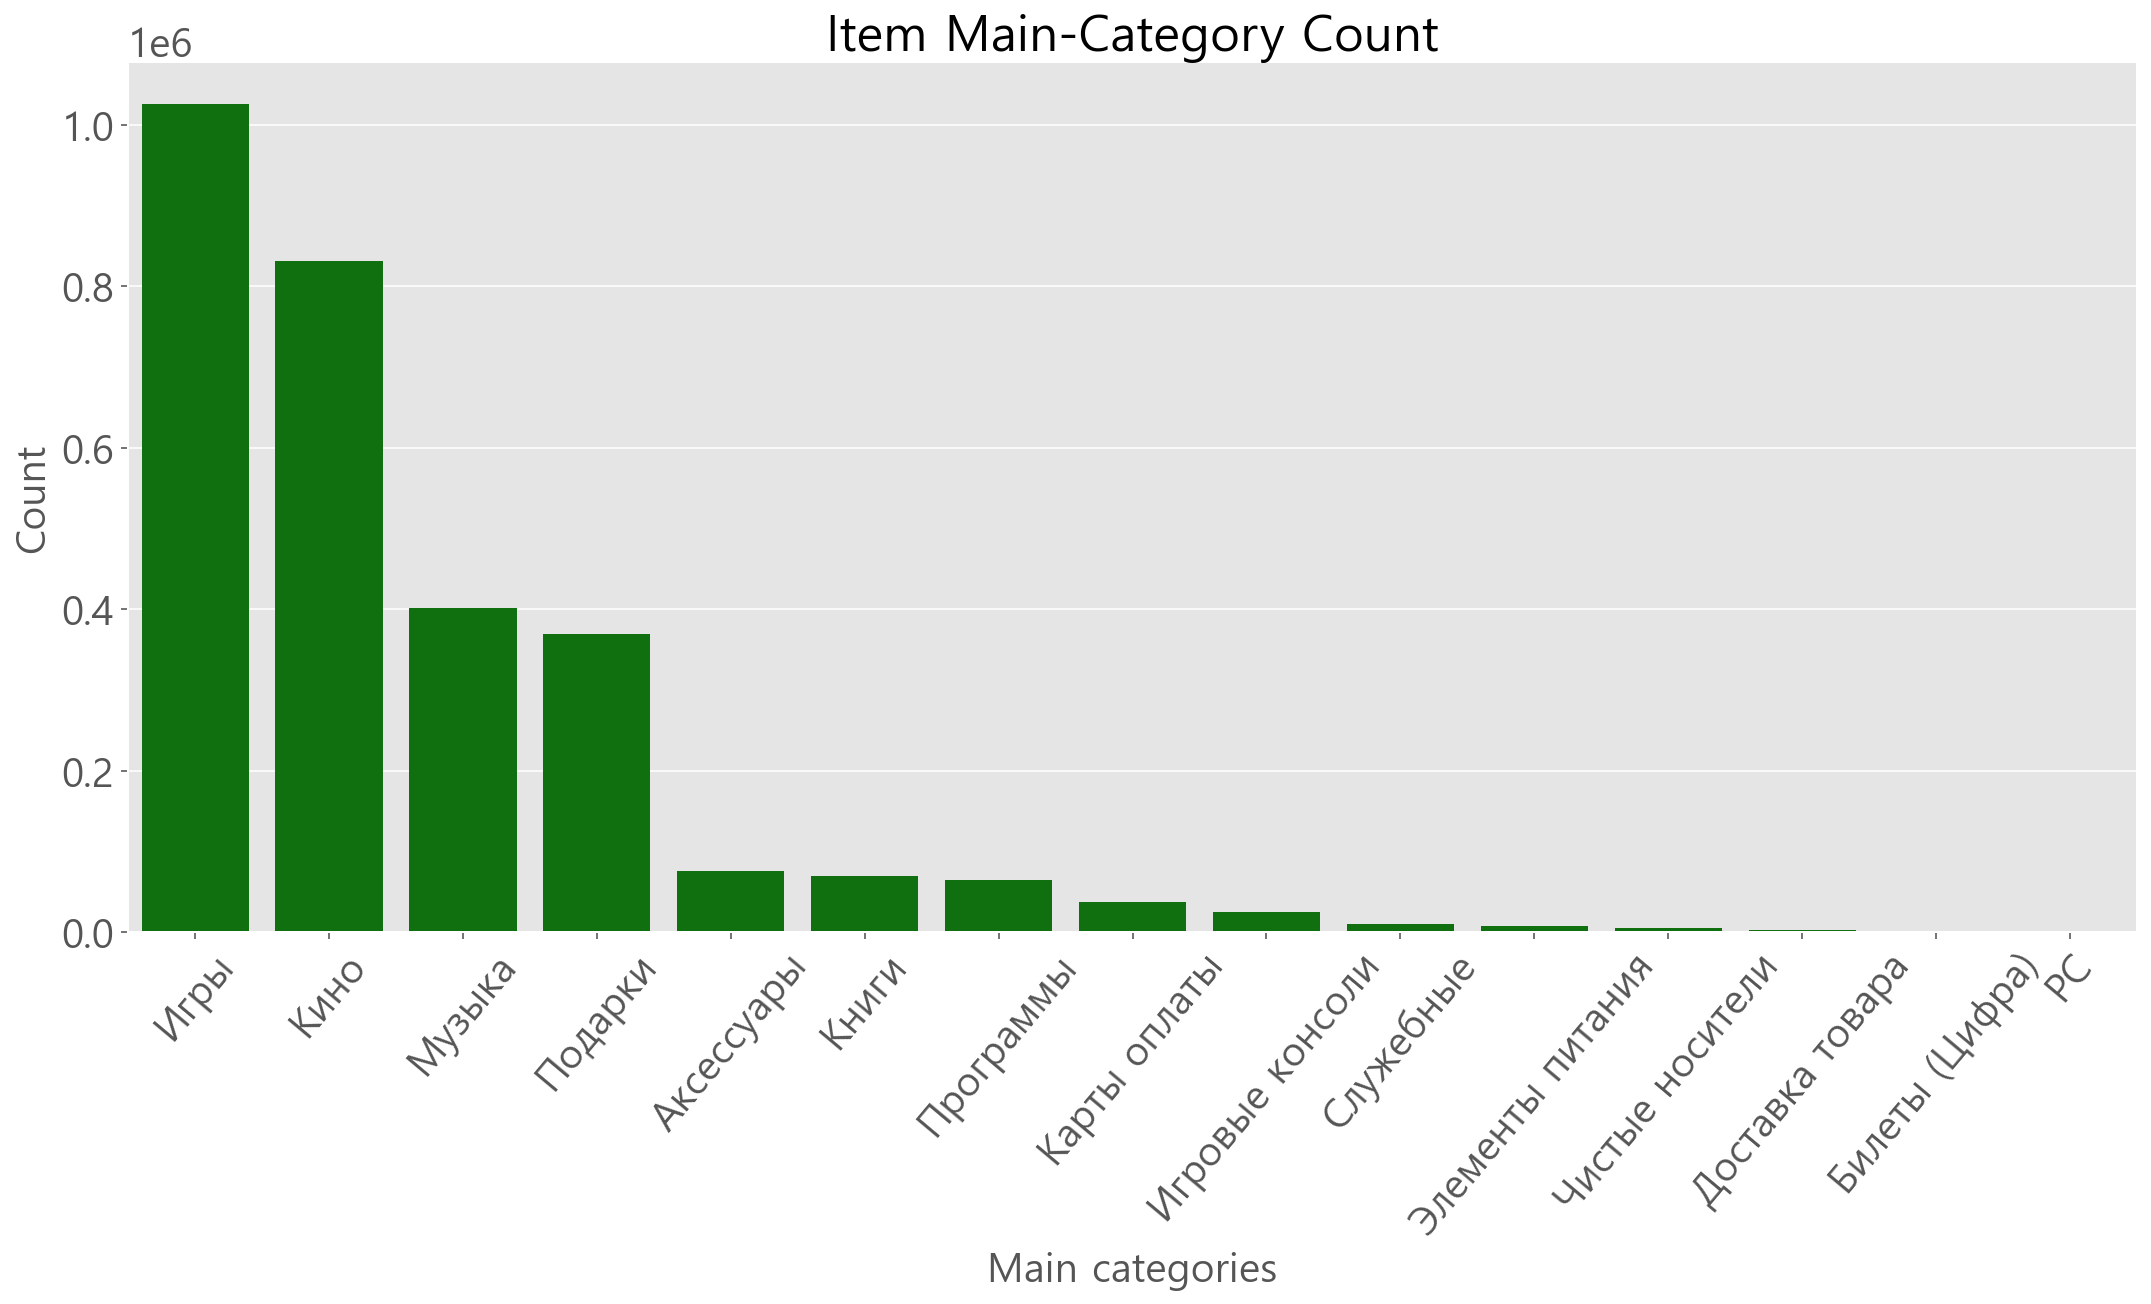

In [36]:
item_m_cat_rank=pd.DataFrame(train['item_maincategory_name'].value_counts())
item_m_cat_rank.reset_index(inplace=True)
item_m_cat_rank.columns = ['item_maincategories', 'counts']

fig, axes = plt.subplots(1,1,figsize = (18,8))

plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

ax=sns.barplot(x='item_maincategories',y='counts', data=item_m_cat_rank, color='g')
ax.set_title('Item Main-Category Count', fontsize=25)
ax.set_xlabel('Main categories', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
plt.xticks(rotation=50)
plt.show()

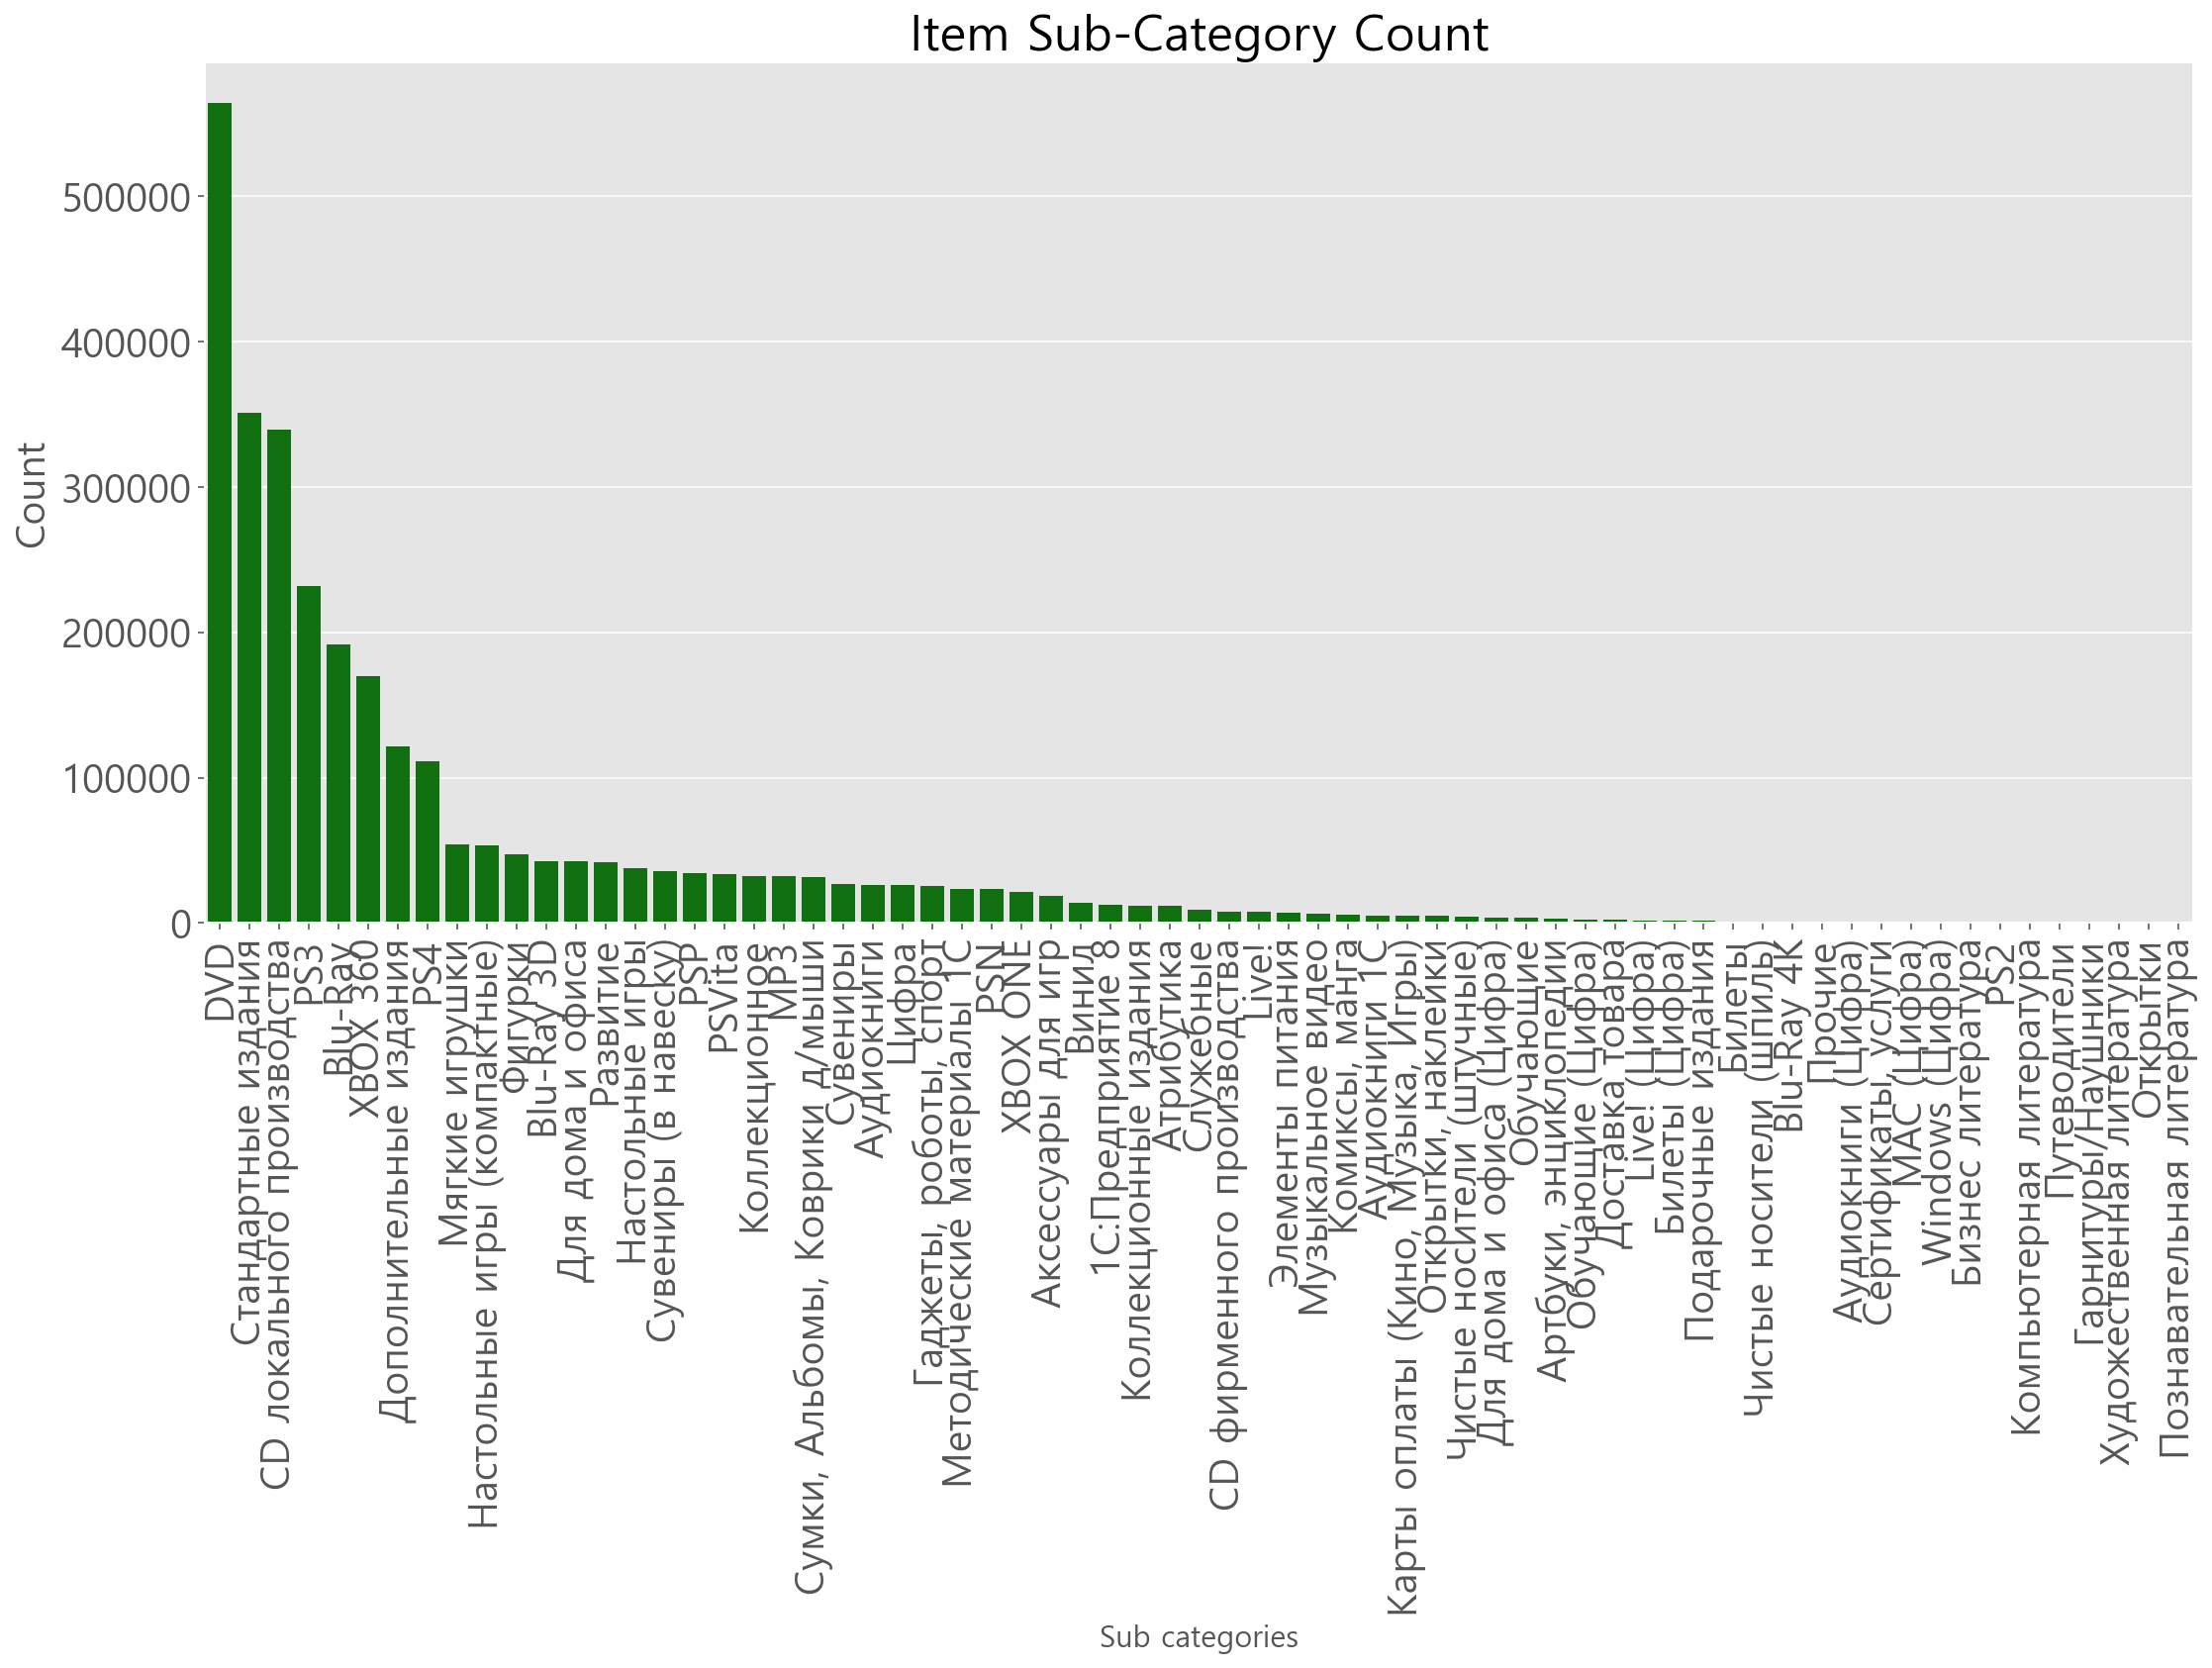

In [37]:
item_s_cat_rank=pd.DataFrame(train['item_subcategory_name'].value_counts())
item_s_cat_rank.reset_index(inplace=True)
item_s_cat_rank.columns = ['item_subcategories', 'counts']

fig, axes = plt.subplots(1,1,figsize = (18,8))

plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

ax=sns.barplot(x='item_subcategories',y='counts', data=item_s_cat_rank, color='g')
ax.set_title('Item Sub-Category Count', fontsize=25)
ax.set_xlabel('Sub categories', fontsize=15)
ax.set_ylabel('Count', fontsize=20)
plt.xticks(rotation=90)
plt.show()

- 게임, 영화, 음악과 같은 entertainment 관련 카테고리가 높은 판매
- 그 다음은 장난감, 장식품과 같은 선물

## 4) Sales Analysis

### Top sales
- 게임관련 item들이 높은 매출을 만듬
- 하드웨어에서 가장 인기있는 item: PS4
- 소프트웨어에서 가장 인기있는 item: Grand Theft Auto

In [38]:
train.groupby('item_name').sum()[['revenue','item_cnt_day']].sort_values('revenue',ascending=False).head()

,revenue,item_cnt_day
item_name,,
Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1108A/B01),2.199410e+08,10313.0
"Grand Theft Auto V [PS3, русские субтитры]",4.369131e+07,16670.0
Комплект Sony PS4 (500 Gb) Black (CUH-1108A/B01) + игра Grand Theft Auto V,3.438623e+07,1368.0
"Grand Theft Auto V [Xbox 360, русские субтитры]",3.116473e+07,11724.0
"Grand Theft Auto V [PS4, русские субтитры]",2.236246e+07,6522.0


### Worst sales

In [39]:
train.groupby('item_name').sum()[['revenue','item_cnt_day']].sort_values('revenue',ascending=True).head()

,revenue,item_cnt_day
item_name,,
Элемент питания КОСМОС LR03 2*BL,7.0,1.0
"Щелкунчик и Крысиный король [PC, Jewel]",14.0,1.0
"Warhammer 40 000. Dawn of War II. Retribution. Набор ""Имперская гвардия"" [PC, Цифровая версия]",15.0,1.0
"Hell Yeah! Набор «Прокачай своего кролика» (СофтКлаб) [PC, Цифровая версия]",17.0,1.0
Ручка (Зеленая),21.0,1.0


### Top Sales Shop
- Moscow 의 대형 상점과 쇼핑몰같은 shop들에서 많은 매출에 기여

In [40]:
train.groupby('shop_name').sum()[['revenue','item_cnt_day']].sort_values('revenue',ascending=False).head()

,revenue,item_cnt_day
shop_name,,
"Москва ТЦ ""Семеновский""",2.356228e+08,311190.0
"Москва ТРК ""Атриум""",2.169356e+08,242216.0
"Москва ТЦ ""МЕГА Теплый Стан"" II",1.601071e+08,184761.0
"СПб ТК ""Невский Центр""",1.522341e+08,145167.0
"Химки ТЦ ""Мега""",1.423631e+08,186113.0


### Worst Sales Shop

In [41]:
train.groupby('shop_name').sum()[['revenue','item_cnt_day']].sort_values('revenue',ascending=True).head()

,revenue,item_cnt_day
shop_name,,
"Новосибирск ТРЦ ""Галерея Новосибирск""",378262.00,332.0
Жуковский ул. Чкалова 39м²,521655.14,572.0
"Воронеж ТРЦ Сити-Парк ""Град""",2353301.00,3602.0
"!Якутск ТЦ ""Центральный"" фран",3238207.00,6311.0
"РостовНаДону ТРК ""Мегацентр Горизонт"" Островной",4308355.72,4956.0


### Top Sales Item Category
- 게임 소프트웨어와 하드웨어가 높은 판매량

In [42]:
train.groupby('item_category_name').sum()[['revenue','item_cnt_day']].sort_values('revenue',ascending=False).head()

,revenue,item_cnt_day
item_category_name,,
Игры - PS3,4.133678e+08,255680.0
Игры - PS4,3.740681e+08,127684.0
Игровые консоли - PS4,2.930456e+08,13266.0
Игры - XBOX 360,2.605658e+08,170525.0
Игры PC - Стандартные издания,2.578938e+08,457265.0


In [43]:
train[["date_block_num","shop_id","item_id","date","item_price","item_cnt_day","revenue"]].groupby(["date_block_num","shop_id","item_id"])\
            .agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum","revenue":"sum"}).head(10)

date            item_price item_cnt_day  \
                                      min        max       mean          sum   
date_block_num shop_id item_id                                                 
0              0       32      2013-01-21 2013-03-01      221.0          6.0   
                       33      2013-01-17 2013-03-01      347.0          3.0   
                       35      2013-01-31 2013-01-31      247.0          1.0   
                       43      2013-01-31 2013-01-31      221.0          1.0   
                       51      2013-01-13 2013-01-31      128.5          2.0   
                       61      2013-10-01 2013-10-01      195.0          1.0   
                       75      2013-01-17 2013-01-17       76.0          1.0   
                       88      2013-01-16 2013-01-16       76.0          1.0   
                       95      2013-06-01 2013-06-01      193.0          1.0   
                       96      2013-10-01 2013-10-01       70.0          1.0   

                               revenue  
                                   sum  
date_block_num shop_id item_id          
0              0       32       1326.0  
                       33       1041.0  
                       35        247.0  
                       43        221.0  
                       51        257.0  
                       61        195.0  
                       75         76.0  
                       88         76.0  
                       95        193.0  
                       96         70.0

### 시계열 그래프
- 뚜렷하게 보이는 변화가 2번 있음 (12개월 주기로)
- 크리스마스 이벤트 또는 연초판매
- 전체적으로 매월 아이템 판매수는 감소, 매출은 감소하는 경향이 없음

C:\Users\jjunghu\AppData\Local\Temp/ipykernel_2984/271568283.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  monthly_ts = train.groupby(["date_block_num"])["revenue","item_cnt_day"].sum()


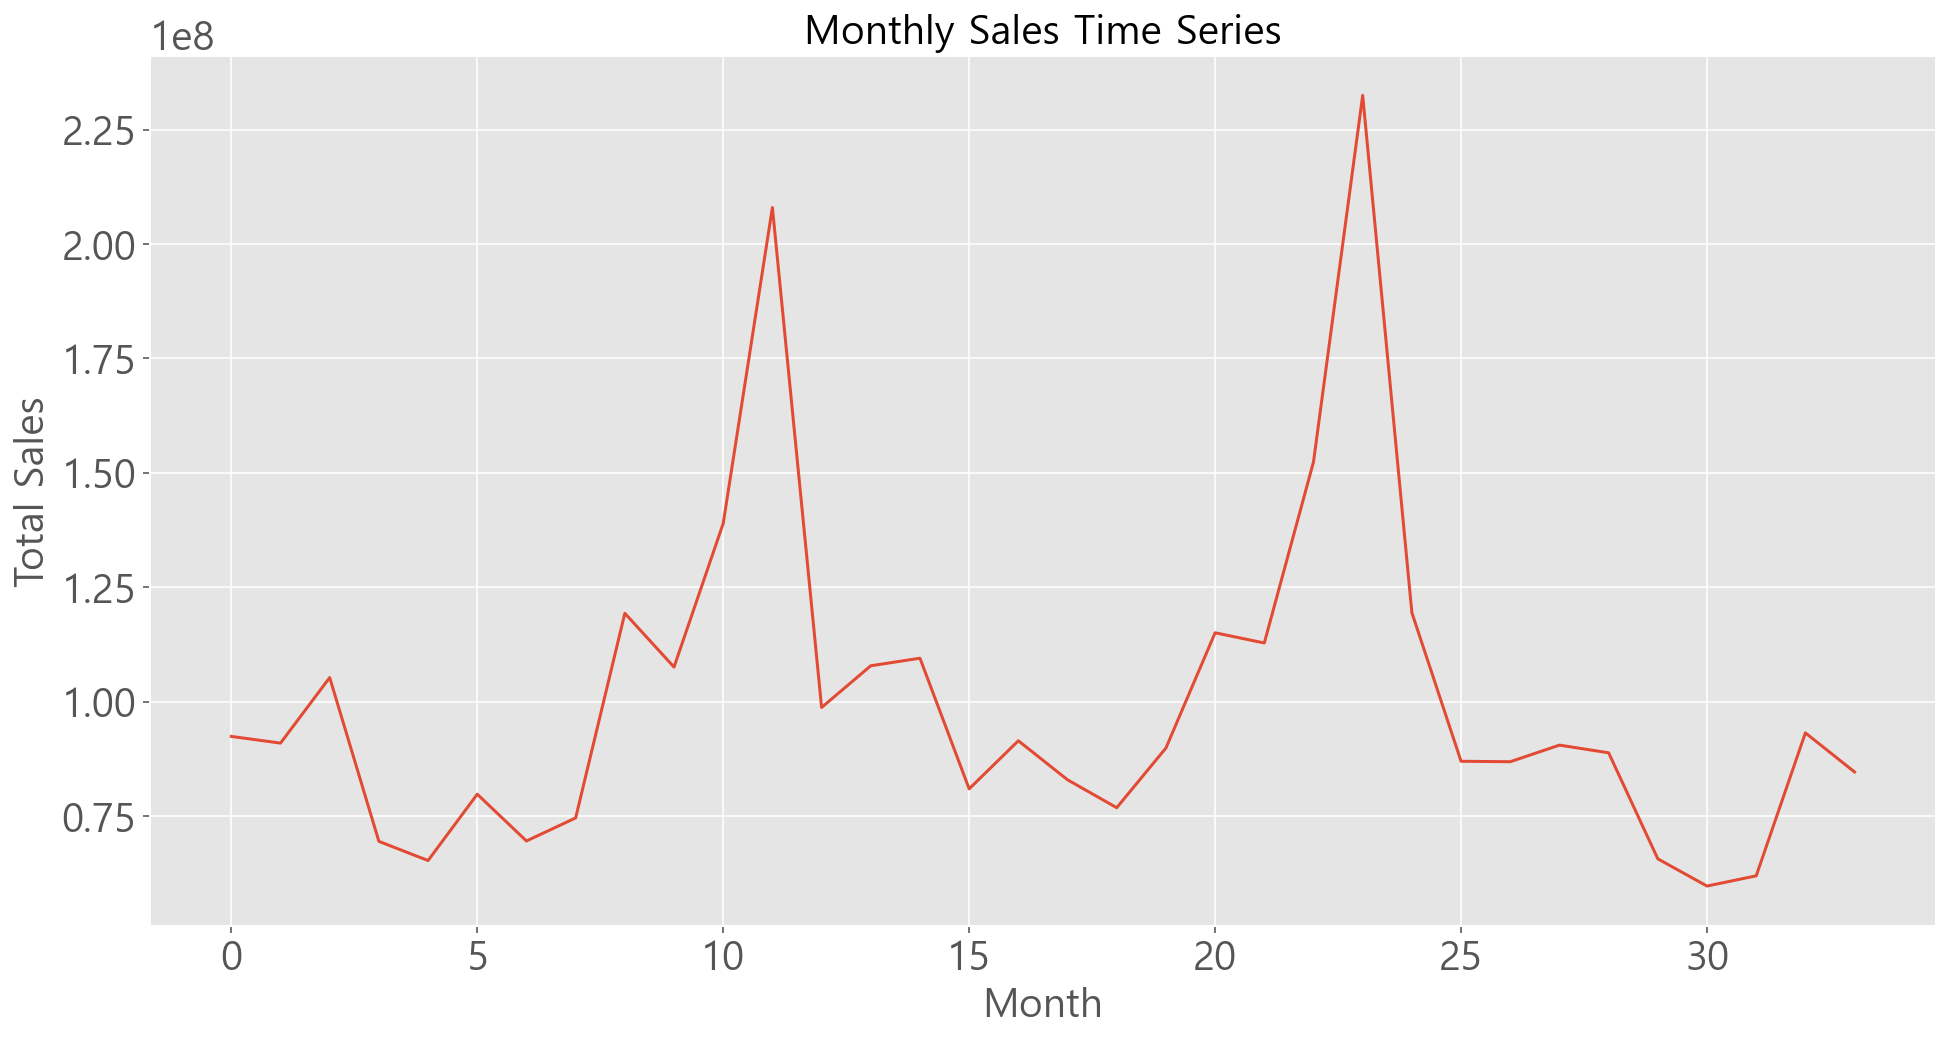

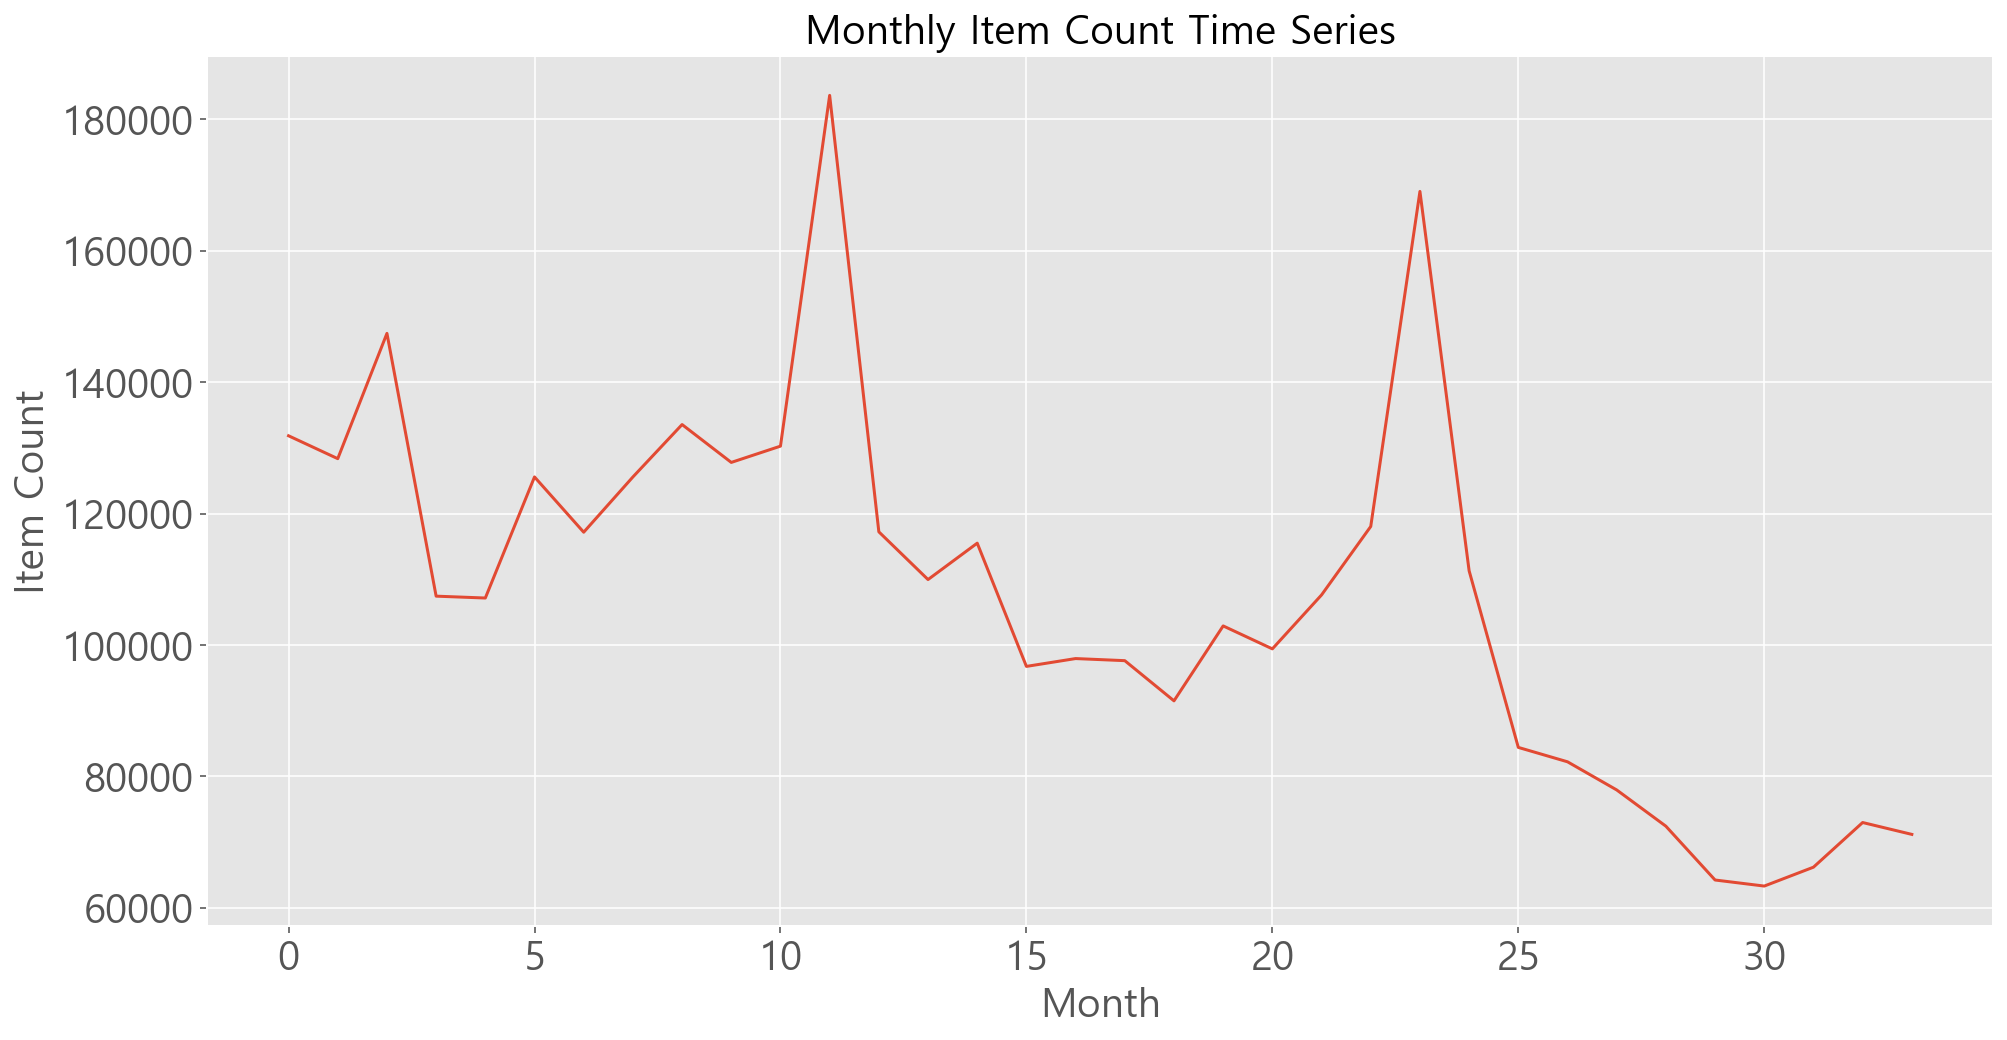

In [44]:
monthly_ts = train.groupby(["date_block_num"])["revenue","item_cnt_day"].sum()

plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

plt.figure(figsize=(16,8))
plt.title('Monthly Sales Time Series', fontsize=20)
plt.xlabel('Month',fontsize=20)
plt.ylabel('Total Sales',fontsize=20)
plt.plot(monthly_ts['revenue'])

plt.figure(figsize=(16,8))
plt.title('Monthly Item Count Time Series',fontsize=20)
plt.xlabel('Month',fontsize=20)
plt.ylabel('Item Count',fontsize=20)
plt.plot(monthly_ts['item_cnt_day'])

plt.show()

## 시계열 EDA

### 시계열 안정성 테스트(ADF, Augmented Dickey-Fuller)
- 귀무가설: 시계열이 안정적이지 않음
- 대립가설: 시계열이 안정적

In [45]:
print('ADF testing ...')
print(f"p-value[revenue] : {adfuller(monthly_ts['revenue'].values, autolag='AIC', regression = 'ct')[1]}")
print(f"p-value[item_cnt_day] : {adfuller(monthly_ts['item_cnt_day'].values, autolag='AIC', regression = 'ct')[1]}")

ADF testing ...
p-value[revenue] : 0.1182173331628365
p-value[item_cnt_day] : 1.9385766151341704e-06


In [46]:
# item_cnt_day의 p-value < 0.05 
# item_cnt_day 는 정상성 시계열

# revenue의 p-value > 0.05 : 시계열이 안정적이지 않음

### 시계열 트렌드
- revenue와 item count 모두 seasonality 갖고있음
- item count는 일관성있게 감소하는 추세, revenue는 중간까지 증가하다가 다시 감소

<Figure size 576x1728 with 0 Axes>

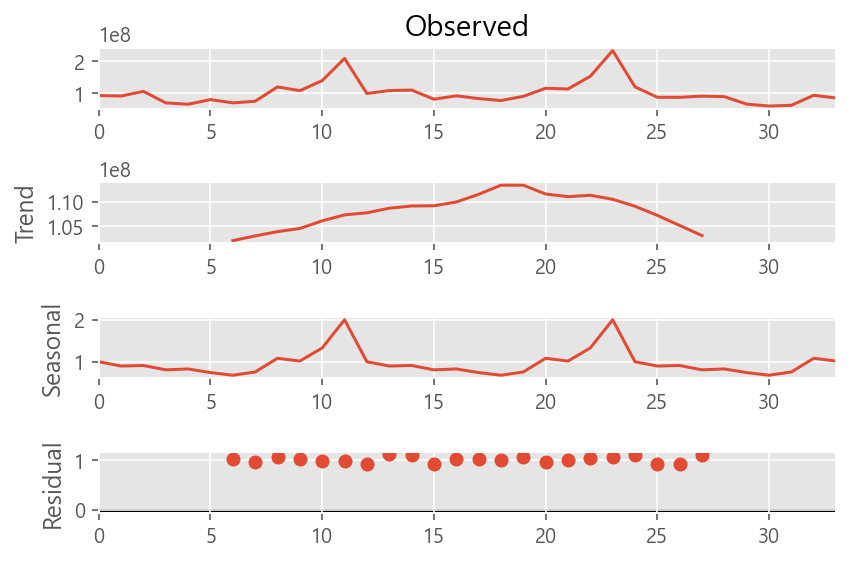

In [47]:
plt.figure(figsize=(8,24))
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

sales_dec = sm.tsa.seasonal_decompose(monthly_ts["revenue"].values,period=12,model="multiplicative").plot()


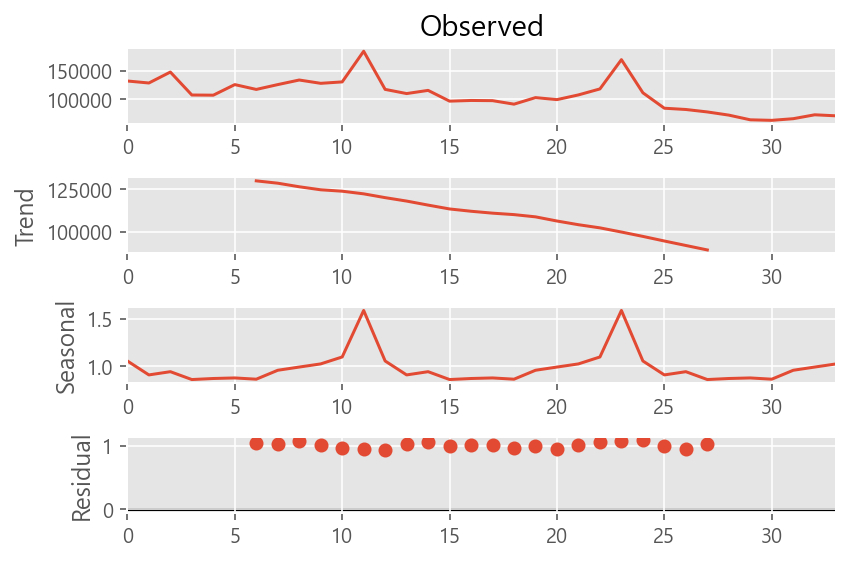

In [48]:
item_cnt_dec = sm.tsa.seasonal_decompose(monthly_ts["item_cnt_day"].values,period=12,model="multiplicative").plot()

### 주기성
- 연마다 주기성을 확인할 수 있음

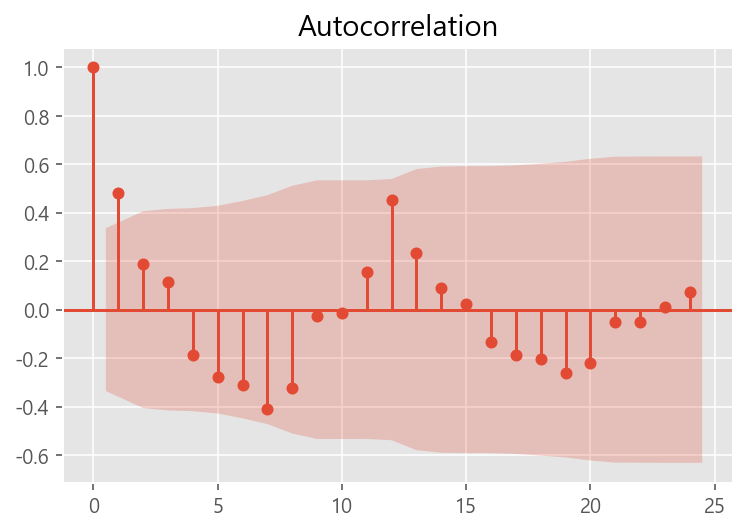

In [49]:
sales_acf = sm.graphics.tsa.plot_acf(monthly_ts["revenue"].values, lags=24)

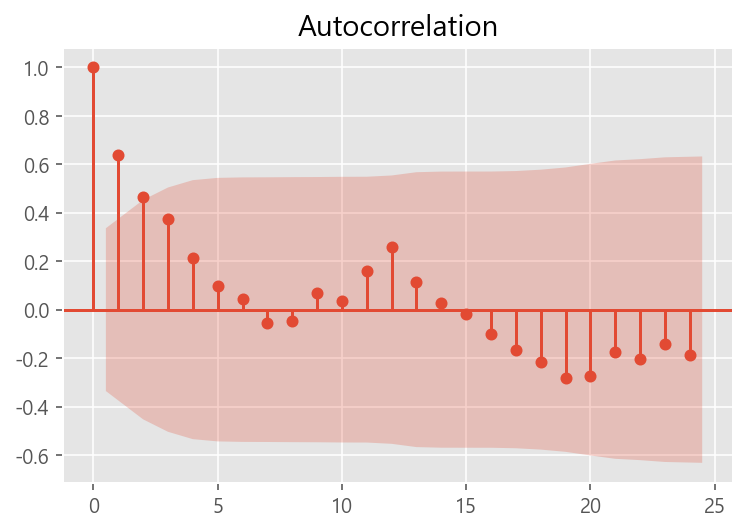

In [50]:
item_cnt_acf = sm.graphics.tsa.plot_acf(monthly_ts["item_cnt_day"].values, lags=24)

### 이상치 확인

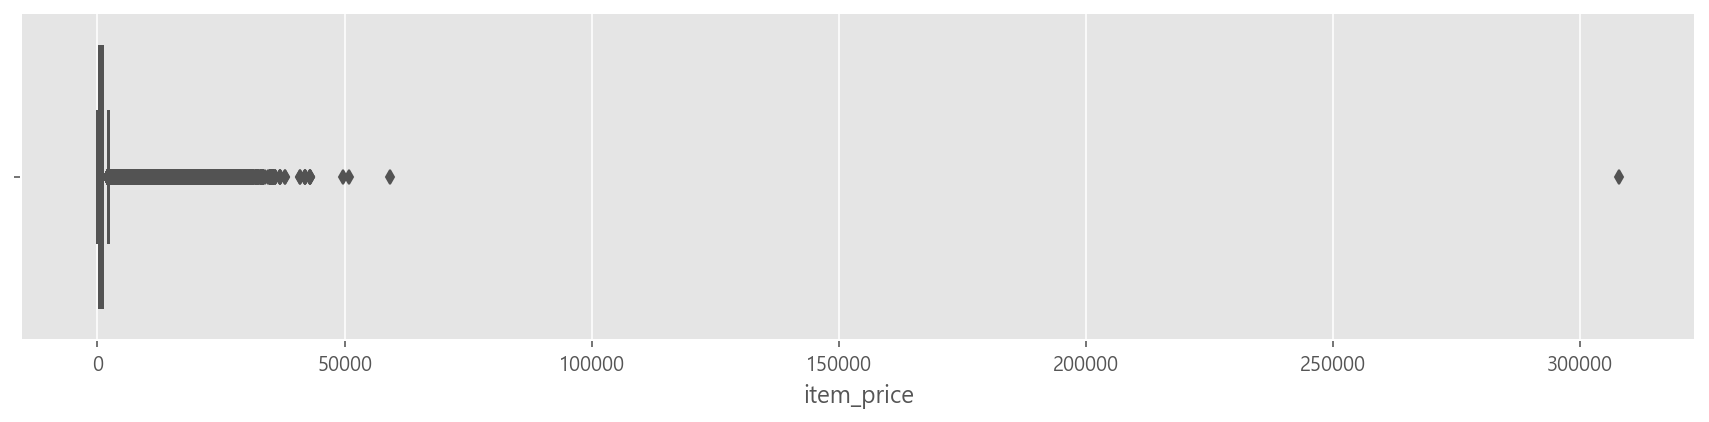

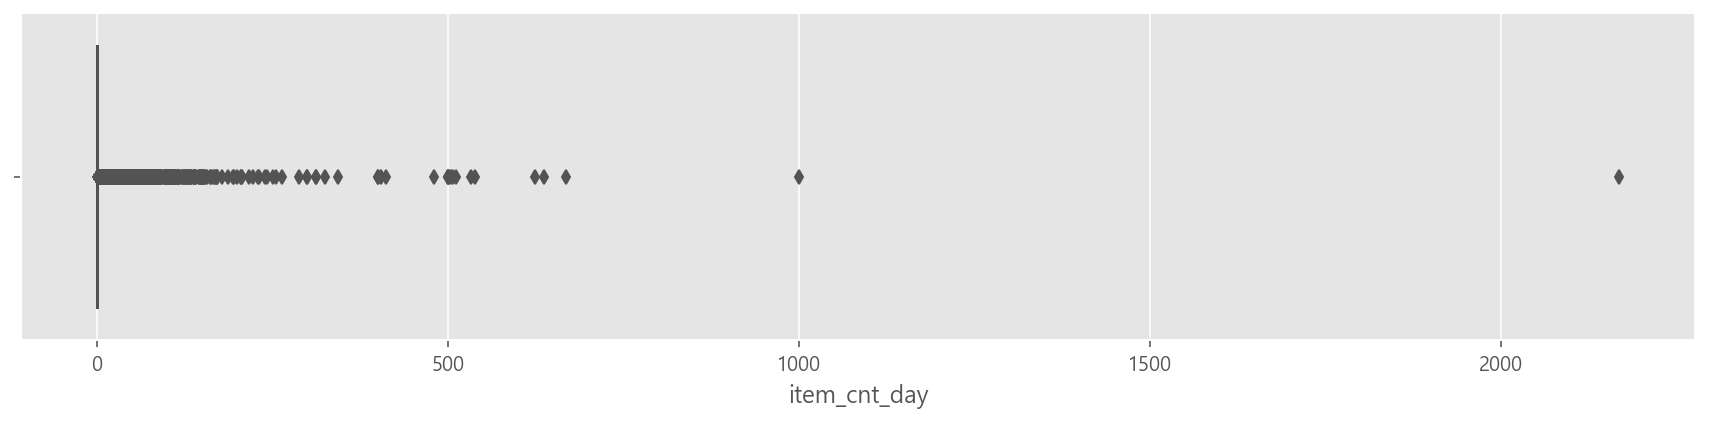

In [51]:
plt.figure(figsize=(15,3))
sns.boxplot(x='item_price', data=sales)

plt.figure(figsize=(15,3))
sns.boxplot(x='item_cnt_day', data=sales)
plt.show()

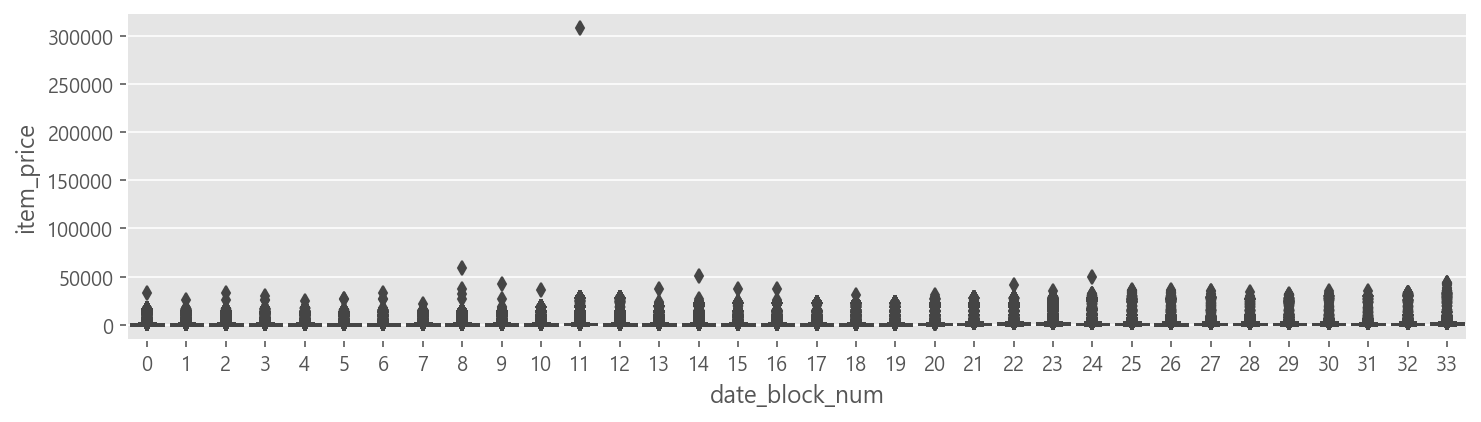

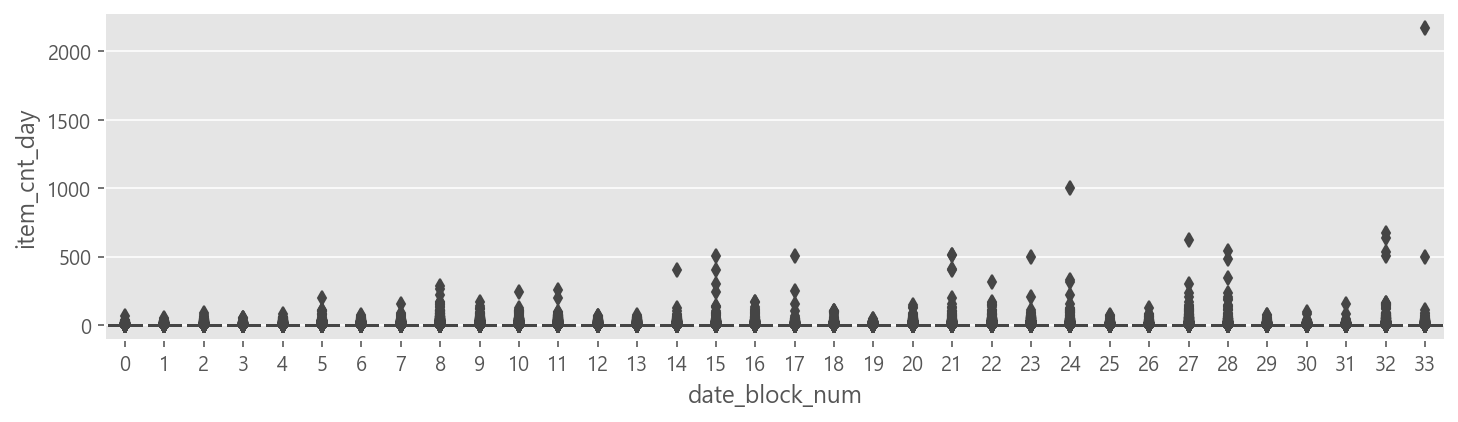

In [52]:
plt.figure(figsize=(12,3))
sns.boxplot(x = 'date_block_num', y = 'item_price', data = sales)
plt.figure(figsize=(12,3))
sns.boxplot(x = 'date_block_num', y = 'item_cnt_day', data = sales)
plt.show()

In [53]:
# 뚜렷한 이상치를 우선 제거 -> 분석하면서 확인하기
sales = sales[sales.item_cnt_day < 500]
sales = sales[sales.item_price < 50000]

In [54]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928492 entries, 0 to 2928491
Data columns (total 17 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date                    datetime64[ns]
 1   date_block_num          int8          
 2   shop_id                 int8          
 3   item_id                 int16         
 4   item_price              float64       
 5   item_cnt_day            float64       
 6   item_name               object        
 7   item_category_id        int16         
 8   item_category_name      object        
 9   item_maincategory_name  object        
 10  item_subcategory_name   object        
 11  item_maincategory_id    int8          
 12  item_subcategory_id     int8          
 13  shop_name               object        
 14  city_name               object        
 15  city_code               int8          
 16  revenue                 float64       
dtypes: datetime64[ns](1), float64(3), int16(2), in

In [55]:
corrMatt = train[['shop_id','item_id','item_price','item_cnt_day','item_category_id',
                'city_code', 'revenue']]
corrMatt = corrMatt.corr()
print(corrMatt)

                   shop_id   item_id  item_price  item_cnt_day  \
shop_id           1.000000  0.029344   -0.023915     -0.005323   
item_id           0.029344  1.000000   -0.134070      0.016298   
item_price       -0.023915 -0.134070    1.000000      0.011906   
item_cnt_day     -0.005323  0.016298    0.011906      1.000000   
item_category_id  0.019337  0.369384   -0.253528      0.014092   
city_code         0.947364  0.030415   -0.027640     -0.006322   
revenue          -0.013551 -0.063382    0.436941      0.407525   

                  item_category_id  city_code   revenue  
shop_id                   0.019337   0.947364 -0.013551  
item_id                   0.369384   0.030415 -0.063382  
item_price               -0.253528  -0.027640  0.436941  
item_cnt_day              0.014092  -0.006322  0.407525  
item_category_id          1.000000   0.019541 -0.117729  
city_code                 0.019541   1.000000 -0.015247  
revenue                  -0.117729  -0.015247  1.000000  


In [56]:
mask = np.array(corrMatt)

In [57]:
mask[np.tril_indices_from(mask)] = False
mask

array([[ 0.        ,  0.02934401, -0.02391473, -0.00532309,  0.01933726,
         0.9473637 , -0.01355065],
       [ 0.        ,  0.        , -0.13406961,  0.01629832,  0.36938435,
         0.03041534, -0.06338228],
       [ 0.        ,  0.        ,  0.        ,  0.01190593, -0.25352805,
        -0.02764022,  0.43694132],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.01409217,
        -0.00632222,  0.40752478],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.01954114, -0.1177287 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.01524716],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ]])

<AxesSubplot:>

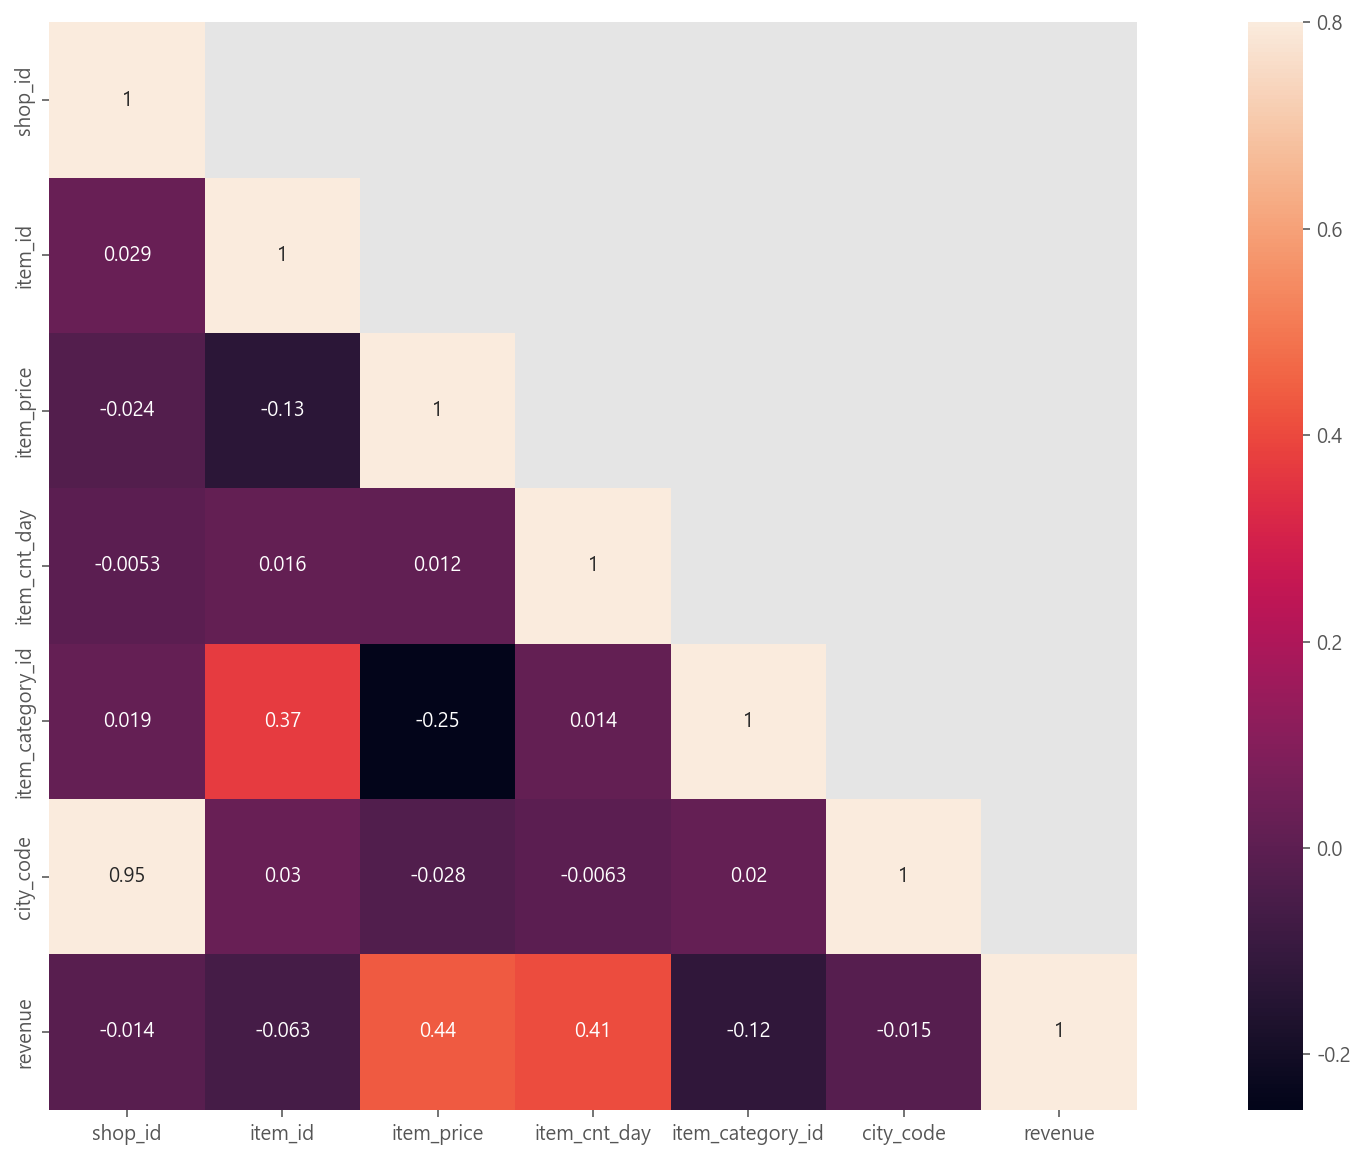

In [58]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

In [59]:
# 전체적으로 의미있는 높은 상관관계는 없어보임

## feature 정해보기

In [60]:
train.drop(['date','item_name', 'item_category_name', 'item_maincategory_name', 'item_subcategory_name', 'shop_name', 'city_name'],axis=1, inplace=True)
test.drop(['ID','item_name', 'item_category_name', 'item_maincategory_name', 'item_subcategory_name', 'shop_name', 'city_name'],axis=1, inplace=True)
data = pd.concat([train, test], ignore_index=True, sort=
                 False, keys=['date_block_num','shop_id','item_id']).fillna(0)
data.head(3)

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,item_maincategory_id,item_subcategory_id,city_code,revenue
0,0,59,22154,999.0,1.0,37,7,1,30,999.0
1,4,59,2573,249.0,1.0,55,9,4,30,249.0
2,0,59,2574,399.0,1.0,55,9,4,30,399.0


In [61]:
feature_df = []
cols = ['date_block_num','shop_id','item_id']

for i in range(35):
    sales = data[data.date_block_num==i]
    feature_df.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
feature_df = pd.DataFrame(np.vstack(feature_df), columns=cols)
feature_df['date_block_num'] = feature_df['date_block_num'].astype(np.int8)
feature_df['shop_id'] = feature_df['shop_id'].astype(np.int8)
feature_df['item_id'] = feature_df['item_id'].astype(np.int16)
feature_df.sort_values(cols,inplace=True)

feature_df = pd.merge(feature_df, shops[['shop_id','city_code']], on=['shop_id'], how='left')
feature_df = pd.merge(feature_df, item_info[['item_id','item_category_id','item_maincategory_id','item_subcategory_id']], on=['item_id'], how='left')
feature_df['city_code'] = feature_df['city_code'].astype(np.int8)
feature_df['item_category_id'] = feature_df['item_category_id'].astype(np.int8)
feature_df['item_maincategory_id'] = feature_df['item_maincategory_id'].astype(np.int8)
feature_df['item_subcategory_id'] = feature_df['item_subcategory_id'].astype(np.int8)

In [62]:
feature_df.head()

,date_block_num,shop_id,item_id,city_code,item_category_id,item_maincategory_id,item_subcategory_id
0,0,0,19,29,40,7,6
1,0,0,27,29,19,5,12
2,0,0,28,29,30,5,57
3,0,0,29,29,23,5,18
4,0,0,32,29,40,7,6


In [63]:
tmp = data.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
tmp.columns = ['item_cnt_month']
tmp.reset_index(inplace=True)
feature_df = pd.merge(feature_df, tmp, on=['date_block_num','shop_id','item_id'], how='left')
feature_df['item_cnt_month'] = (feature_df['item_cnt_month'].fillna(0).clip(0,20).astype(np.float16))

In [64]:
feature_df['christmas'] = np.where(feature_df['date_block_num'].isin([11,23]), 1,0)
feature_df

,date_block_num,shop_id,item_id,city_code,item_category_id,item_maincategory_id,item_subcategory_id,item_cnt_month,christmas
0,0,0,19,29,40,7,6,0.0,0
1,0,0,27,29,19,5,12,0.0,0
2,0,0,28,29,30,5,57,0.0,0
3,0,0,29,29,23,5,18,0.0,0
4,0,0,32,29,40,7,6,6.0,0
...,...,...,...,...,...,...,...,...,...
11098749,34,59,22162,30,40,7,6,0.0,0
11098750,34,59,22163,30,40,7,6,0.0,0
11098751,34,59,22164,30,37,7,1,0.0,0
11098752,34,59,22166,30,54,8,63,0.0,0


### lag

In [65]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

- Item count by month for 1,3,6,12 lag

In [66]:
feature_df = lag_feature(feature_df, [1,3,6,12], 'item_cnt_month')

- Item count mean by month for 1 lag

In [67]:
tmp = feature_df.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
tmp.columns = ['item_cnt_month_avg']
tmp.reset_index(inplace=True)

feature_df = pd.merge(feature_df, tmp, on=['date_block_num'], how='left')
feature_df['item_cnt_month_avg'] = feature_df['item_cnt_month_avg'].astype(np.float16)
feature_df = lag_feature(feature_df, [1], 'item_cnt_month_avg')

- Item count mean by month/item for 1,3,6,12 lag

In [68]:
tmp = feature_df.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
tmp.columns = ['item_cnt_month_item_avg']
tmp.reset_index(inplace=True)

feature_df = pd.merge(feature_df, tmp, on=['date_block_num','item_id'], how='left')
feature_df['item_cnt_month_item_avg'] = feature_df['item_cnt_month_item_avg'].astype(np.float16)
feature_df = lag_feature(feature_df, [1,3,6,12], 'item_cnt_month_item_avg')

- Item count mean by month/item_category for 1 lag

In [69]:
tmp = feature_df.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
tmp.columns = ['item_cnt_month_cat_avg']
tmp.reset_index(inplace=True)

feature_df = pd.merge(feature_df, tmp, on=['date_block_num','item_category_id'], how='left')
feature_df['item_cnt_month_cat_avg'] = feature_df['item_cnt_month_cat_avg'].astype(np.float16)
feature_df = lag_feature(feature_df, [1], 'item_cnt_month_cat_avg')

- Item count mean by month/shop for 1,3,6,12 lag

In [70]:
tmp = feature_df.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
tmp.columns = ['item_cnt_month_shop_avg']
tmp.reset_index(inplace=True)

feature_df = pd.merge(feature_df, tmp, on=['date_block_num','shop_id'], how='left')
feature_df['item_cnt_month_shop_avg'] = feature_df['item_cnt_month_shop_avg'].astype(np.float16)
feature_df = lag_feature(feature_df, [1,3,6,12], 'item_cnt_month_shop_avg')

- Item count mean by month/main item category for 1 lag

In [71]:
tmp = feature_df.groupby(['date_block_num', 'item_maincategory_id']).agg({'item_cnt_month': ['mean']})
tmp.columns = ['item_cnt_month_maincat_avg']
tmp.reset_index(inplace=True)

feature_df = pd.merge(feature_df, tmp, on=['date_block_num','item_maincategory_id'], how='left')
feature_df['item_cnt_month_maincat_avg'] = feature_df['item_cnt_month_maincat_avg'].astype(np.float16)
feature_df = lag_feature(feature_df, [1], 'item_cnt_month_maincat_avg')

- Item count mean by month/main item category/shop for 1 lag

In [72]:
tmp = feature_df.groupby(['date_block_num', 'item_maincategory_id', 'shop_id']).agg({'item_cnt_month': ['mean']})
tmp.columns = ['item_cnt_month_maincat_shop_avg']
tmp.reset_index(inplace=True)

feature_df = pd.merge(feature_df, tmp, on=['date_block_num','item_maincategory_id','shop_id'], how='left')
feature_df['item_cnt_month_maincat_shop_avg'] = feature_df['item_cnt_month_maincat_shop_avg'].astype(np.float16)
feature_df = lag_feature(feature_df, [1], 'item_cnt_month_maincat_shop_avg')

- Item count mean by month/sub item category for 1 lag

In [73]:
tmp = feature_df.groupby(['date_block_num', 'item_subcategory_id']).agg({'item_cnt_month': ['mean']})
tmp.columns = ['item_cnt_month_subcat_avg']
tmp.reset_index(inplace=True)

feature_df = pd.merge(feature_df, tmp, on=['date_block_num','item_subcategory_id'], how='left')
feature_df['item_cnt_month_subcat_avg'] = feature_df['item_cnt_month_subcat_avg'].astype(np.float16)
feature_df = lag_feature(feature_df, [1], 'item_cnt_month_subcat_avg')

- Item count mean by month/sub item category/shop for 1 lag

In [74]:
tmp = feature_df.groupby(['date_block_num', 'item_subcategory_id', 'shop_id']).agg({'item_cnt_month': ['mean']})
tmp.columns = ['item_cnt_month_subcat_shop_avg']
tmp.reset_index(inplace=True)

feature_df = pd.merge(feature_df, tmp, on=['date_block_num','item_subcategory_id','shop_id'], how='left')
feature_df['item_cnt_month_subcat_shop_avg'] = feature_df['item_cnt_month_subcat_shop_avg'].astype(np.float16)
feature_df = lag_feature(feature_df, [1], 'item_cnt_month_subcat_shop_avg')

- Item count mean by month/city for 1,3,6,12 lag

In [75]:
tmp = feature_df.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
tmp.columns = ['item_cnt_month_city_avg']
tmp.reset_index(inplace=True)

feature_df = pd.merge(feature_df, tmp, on=['date_block_num','city_code'], how='left')
feature_df['item_cnt_month_city_avg'] = feature_df['item_cnt_month_city_avg'].astype(np.float16)
feature_df = lag_feature(feature_df, [1,3,6,12], 'item_cnt_month_city_avg')

- Item count mean by month/city/item for 1,3,6,12 lag

In [76]:
tmp = feature_df.groupby(['date_block_num', 'city_code', 'item_id']).agg({'item_cnt_month': ['mean']})
tmp.columns = ['item_cnt_month_city_item_avg']
tmp.reset_index(inplace=True)

feature_df = pd.merge(feature_df, tmp, on=['date_block_num','city_code','item_id'], how='left')
feature_df['item_cnt_month_city_item_avg'] = feature_df['item_cnt_month_city_item_avg'].astype(np.float16)
feature_df = lag_feature(feature_df, [1,3,6,12], 'item_cnt_month_city_item_avg')

In [77]:
del tmp
gc.collect()

49555

In [78]:
feature_df.head()

,date_block_num,shop_id,item_id,city_code,item_category_id,item_maincategory_id,item_subcategory_id,item_cnt_month,christmas,item_cnt_month_lag_1,...,item_cnt_month_city_avg,item_cnt_month_city_avg_lag_1,item_cnt_month_city_avg_lag_3,item_cnt_month_city_avg_lag_6,item_cnt_month_city_avg_lag_12,item_cnt_month_city_item_avg,item_cnt_month_city_item_avg_lag_1,item_cnt_month_city_item_avg_lag_3,item_cnt_month_city_item_avg_lag_6,item_cnt_month_city_item_avg_lag_12
0,0,0,19,29,40,7,6,0.0,0,NaN,...,0.51416,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1,0,0,27,29,19,5,12,0.0,0,NaN,...,0.51416,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN
2,0,0,28,29,30,5,57,0.0,0,NaN,...,0.51416,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
3,0,0,29,29,23,5,18,0.0,0,NaN,...,0.51416,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN
4,0,0,32,29,40,7,6,6.0,0,NaN,...,0.51416,NaN,NaN,NaN,NaN,6.5,NaN,NaN,NaN,NaN


- Month number / number of days in a month

In [79]:
feature_df['month'] = feature_df['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
feature_df['days_num'] =  feature_df['month'].map(days).astype(np.int8)

- revenue trend

In [80]:
revenue_df = feature_df[['date_block_num','shop_id','item_id']]

#sum of shop& month revenue
tmp1 = data.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
tmp1.columns = ['date_shop_revenue']
tmp1.reset_index(inplace=True)
revenue_df = pd.merge(revenue_df, tmp1, on=['date_block_num','shop_id'], how='left')
revenue_df['date_shop_revenue'] = revenue_df['date_shop_revenue'].astype(np.float32)

#mean of sum of shop& month revenue in all date
tmp2 = revenue_df.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
tmp2.columns = ['shop_avg_revenue']
tmp2.reset_index(inplace=True)
revenue_df = pd.merge(revenue_df, tmp2, on=['shop_id'], how='left')
revenue_df['shop_avg_revenue'] = revenue_df['shop_avg_revenue'].astype(np.float32)

revenue_df['delta_revenue'] = (revenue_df['date_shop_revenue'] - revenue_df['shop_avg_revenue']) / revenue_df['shop_avg_revenue']
revenue_df['delta_revenue'] = revenue_df['delta_revenue'].astype(np.float16)

feature_df['delta_revenue'] = revenue_df['delta_revenue']

- Number of days after first sale

In [81]:
feature_df['item_shop_first_sale'] = feature_df['date_block_num'] - feature_df.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
feature_df['item_first_sale'] = feature_df['date_block_num'] - feature_df.groupby('item_id')['date_block_num'].transform('min')

In [82]:
feature_df = feature_df[feature_df.date_block_num > 11]

- Fill null value with 0 for lag features

In [83]:
for col in feature_df.columns:
    if ('_lag_' in col) & (feature_df[col].isnull().any()):
        feature_df[col].fillna(0, inplace=True)

In [84]:
feature_df.isnull().sum()

date_block_num                           0
shop_id                                  0
item_id                                  0
city_code                                0
item_category_id                         0
item_maincategory_id                     0
item_subcategory_id                      0
item_cnt_month                           0
christmas                                0
item_cnt_month_lag_1                     0
item_cnt_month_lag_3                     0
item_cnt_month_lag_6                     0
item_cnt_month_lag_12                    0
item_cnt_month_avg                       0
item_cnt_month_avg_lag_1                 0
item_cnt_month_item_avg                  0
item_cnt_month_item_avg_lag_1            0
item_cnt_month_item_avg_lag_3            0
item_cnt_month_item_avg_lag_6            0
item_cnt_month_item_avg_lag_12           0
item_cnt_month_cat_avg                   0
item_cnt_month_cat_avg_lag_1             0
item_cnt_month_shop_avg                  0
item_cnt_mo

In [85]:
feature_df.columns

Index(['date_block_num', 'shop_id', 'item_id', 'city_code', 'item_category_id',
       'item_maincategory_id', 'item_subcategory_id', 'item_cnt_month',
       'christmas', 'item_cnt_month_lag_1', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12', 'item_cnt_month_avg',
       'item_cnt_month_avg_lag_1', 'item_cnt_month_item_avg',
       'item_cnt_month_item_avg_lag_1', 'item_cnt_month_item_avg_lag_3',
       'item_cnt_month_item_avg_lag_6', 'item_cnt_month_item_avg_lag_12',
       'item_cnt_month_cat_avg', 'item_cnt_month_cat_avg_lag_1',
       'item_cnt_month_shop_avg', 'item_cnt_month_shop_avg_lag_1',
       'item_cnt_month_shop_avg_lag_3', 'item_cnt_month_shop_avg_lag_6',
       'item_cnt_month_shop_avg_lag_12', 'item_cnt_month_maincat_avg',
       'item_cnt_month_maincat_avg_lag_1', 'item_cnt_month_maincat_shop_avg',
       'item_cnt_month_maincat_shop_avg_lag_1', 'item_cnt_month_subcat_avg',
       'item_cnt_month_subcat_avg_lag_1', 'item_cnt_month_subc

In [86]:
feature_df.head()

,date_block_num,shop_id,item_id,city_code,item_category_id,item_maincategory_id,item_subcategory_id,item_cnt_month,christmas,item_cnt_month_lag_1,...,item_cnt_month_city_item_avg,item_cnt_month_city_item_avg_lag_1,item_cnt_month_city_item_avg_lag_3,item_cnt_month_city_item_avg_lag_6,item_cnt_month_city_item_avg_lag_12,month,days_num,delta_revenue,item_shop_first_sale,item_first_sale
4478890,12,2,27,0,19,5,12,0.0,0,0.0,...,0.0,0.0,0.0,0.0,1.0,0,31,-0.166504,12,12
4478891,12,2,30,0,40,7,6,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,31,-0.166504,11,11
4478892,12,2,31,0,37,7,1,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,31,-0.166504,11,11
4478893,12,2,32,0,40,7,6,1.0,0,0.0,...,1.0,0.0,0.0,0.0,0.0,0,31,-0.166504,12,12
4478894,12,2,33,0,37,7,1,1.0,0,1.0,...,1.0,1.0,0.0,0.0,1.0,0,31,-0.166504,12,12


In [88]:
# import pickle

# with open( 'feature_df', "wb" ) as file:
#     pickle.dump( feature_df, file)

In [89]:
with open( 'feature_df', "rb" ) as file:
    feature_data = pickle.load(file)

### PCA 주성분 분석

In [91]:
from sklearn.preprocessing import StandardScaler

x = feature_data.drop(['item_cnt_month'], axis=1)
y = feature_data['item_cnt_month']

In [92]:
x, y

(          date_block_num  shop_id  item_id  city_code  item_category_id  \
 4478890               12        2       27          0                19   
 4478891               12        2       30          0                40   
 4478892               12        2       31          0                37   
 4478893               12        2       32          0                40   
 4478894               12        2       33          0                37   
 ...                  ...      ...      ...        ...               ...   
 11098749              34       59    22162         30                40   
 11098750              34       59    22163         30                40   
 11098751              34       59    22164         30                37   
 11098752              34       59    22166         30                54   
 11098753              34       59    22167         30                49   
 
           item_maincategory_id  item_subcategory_id  christmas  \
 4478890           

In [93]:
type(y)

pandas.core.series.Series

In [94]:
col_list =[]
for i in x.columns:
    if ('id' in i) | ('ID' in i) | ('date_block_num' in i) | ('christmas' in i):
        pass
    else:
        col_list.append(i)
col_list
k = x.copy()
for i in col_list:
    k.loc[:,i] = StandardScaler().fit_transform(np.array(k.loc[:,i]).reshape(-1,1))

In [95]:
data2 = pd.concat([k, y], axis=1)

In [96]:
with open( 'data2', "wb" ) as file:
    pickle.dump( data2, file)

In [92]:
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection 

# x_train = feature_df[feature_df.date_block_num < 33].drop(['item_cnt_month'], axis=1)
# y_train = feature_df[feature_df.date_block_num < 33]['item_cnt_month']

# x_valid = feature_df[feature_df.date_block_num == 33].drop(['item_cnt_month'], axis=1)
# y_valid = feature_df[feature_df.date_block_num == 33]['item_cnt_month']

In [ ]:
# x_train = feature_df[feature_df.date_block_num < 34].drop(['item_cnt_month'], axis=1)
# y_train = feature_df[feature_df.date_block_num < 34]['item_cnt_month']

# x_test = feature_df[feature_df.date_block_num == 34].drop(['item_cnt_month'], axis=1)
# y_test= feature_df[feature_df.date_block_num == 34]['item_cnt_month']